# description 5/01/19 clinically guided aggregation modeling

sklearn modeling using local methods of the median imputed training data using origional min/max clinically guided aggregation. note the preprocessing of data from 07.20-worst_case_model was performed in R (09.newagg2_preprocessing_med_impute.rmd). this eventually will be converted over to python, but for now works in r. 

preprocessing includes variable formatting (categorical to factor variables in r, train/test split, and median imputation).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, Imputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import validation
from scipy.sparse import issparse
from scipy.spatial import distance
from sklearn import svm


#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'


#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# warnings.filterwarnings(action='ignore', category=DeprecationWarning)


memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})


%load_ext autotime

# functions related to gower distance, preprocessing, finding train samples, etc...

In [2]:
def _return_float_dtype(X, Y):
    ##used in grower distance, converts values to floats for formatting.
    """
    1. If dtype of X and Y is float32, then dtype float32 is returned.
    2. Else dtype float is returned.
    """
    if not issparse(X) and not isinstance(X, np.ndarray):
        X = np.asarray(X)

    if Y is None:
        Y_dtype = X.dtype
    elif not issparse(Y) and not isinstance(Y, np.ndarray):
        Y = np.asarray(Y)
        Y_dtype = Y.dtype
    else:
        Y_dtype = Y.dtype

    if X.dtype == Y_dtype == np.float32:
        dtype = np.float32
    elif X.dtype == np.object and not issparse(X):
        dtype = np.float
        for col in range(X.shape[1]):
            if not np.issubdtype(type(X[0, col]), np.number):
                dtype = np.object
                break
    else:
        dtype = np.float
    return X, Y, dtype


time: 38.4 ms


In [3]:
def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    ##used in grower distance, checks x and y dimensions against each otehr.
    X, Y, dtype_float = _return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = 'check_pairwise_arrays'
    if dtype is None:
        dtype = dtype_float
    
    ##Input validation on an array, list, sparse matrix or similar.
    ##By default, the input is checked to be a non-empty 2D array containing only finite values.
    
    if Y is X or Y is None:
        X = Y = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                            warn_on_dtype=warn_on_dtype, estimator=estimator)
    else:
        X = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)
        Y = validation.check_array(Y, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError("Precomputed metric requires shape "
                             "(n_queries, n_indexed). Got (%d, %d) "
                             "for %d indexed." %
                             (X.shape[0], X.shape[1], Y.shape[0]))
    elif X.shape[1] != Y.shape[1]:
        raise ValueError("Incompatible dimension for X and Y matrices: "
                         "X.shape[1] == %d while Y.shape[1] == %d" % (
                             X.shape[1], Y.shape[1]))

    return X, Y

time: 24.2 ms


In [4]:
def gower_distances(X, Y=None, w=None, categorical_features=None):
    """
    Computes the gower distances between X and Y

    Read more in the :ref:`User Guide <metrics>`.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)

    Y : array-like, shape (n_samples, n_features)

    w:  array-like, shape (n_features)
    According the Gower formula, w is an attribute weight.

    categorical_features: array-like, shape (n_features)
    Indicates with True/False wheter a column is a categorical attribute.
    This is useful when categorical atributes are represented as integer
    values.

    Returns
    -------
    similarities : ndarray, shape (n_samples, )

    Notes
    ------
    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    """

    X, Y = check_pairwise_arrays(X, Y, dtype=(np.object, None)[issparse(X) or
                                                               issparse(Y)])
    rows, cols = X.shape

    if categorical_features is None:
        categorical_features = []
        for col in range(cols):
            if np.issubdtype(type(X[0, col]), np.number):
                categorical_features.append(False)
            else:
                categorical_features.append(True)
    # Calculates the normalized ranges and max values of numeric values
    ranges_of_numeric = [0.0] * cols
    max_of_numeric = [0.0] * cols
    for col in range(cols):
        if not categorical_features[col]:
            max = None
            min = None
            if issparse(X):
                col_array = X.getcol(col)
                max = col_array.max() + 0.0
                min = col_array.min() + 0.0
            else:
                col_array = X[:, col].astype(np.double)
                max = np.nanmax(col_array)
                min = np.nanmin(col_array)

            if np.isnan(max):
                max = 0.0
            if np.isnan(min):
                min = 0.0
            max_of_numeric[col] = max
            ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0

    if w is None:
        w = [1] * cols

    yrows, ycols = Y.shape

    dm = np.zeros((rows, yrows), dtype=np.double)

    for i in range(0, rows):
        j_start = i

        # for non square results
        if rows != yrows:
            j_start = 0

        for j in range(j_start, yrows):
            sum_sij = 0.0
            sum_wij = 0.0
            for col in range(cols):
                value_xi = X[i, col]
                value_xj = Y[j, col]

                if not categorical_features[col]:
                    if (max_of_numeric[col] != 0):
                        value_xi = value_xi / max_of_numeric[col]
                        value_xj = value_xj / max_of_numeric[col]
                    else:
                        value_xi = 0
                        value_xj = 0

                    if ranges_of_numeric[col] != 0:
                        sij = abs(value_xi - value_xj) / ranges_of_numeric[col]
                    else:
                        sij = 0
                    wij = (w[col], 0)[np.isnan(value_xi) or np.isnan(value_xj)]
                else:
                    sij = (1.0, 0.0)[value_xi == value_xj]
                    wij = (w[col], 0)[value_xi is None and value_xj is None]
                sum_sij += (wij * sij)
                sum_wij += wij

            if sum_wij != 0:
                dm[i, j] = (sum_sij / sum_wij)
                if j < rows and i < yrows:
                    dm[j, i] = dm[i, j]
    return dm


time: 224 ms


In [5]:
# ##testing grower distance
# x_train1=x_train.iloc[:100,1:20]
# x_train2=x_train.iloc[101:201,1:20]
# print(len(x_train1), #2715
# len(x_train2)) #2715

time: 833 µs


In [6]:
# gower_distances(X=x_train1, Y=x_train2, w=None, categorical_features=None) #works

time: 543 µs


In [7]:
def select_train_samples(sample_id, all_xy, m, time_interval):# m is number of similar cases or controls
    num_control = m   # the ratio of case and control is 1:2, 1:3,1:4
    
    ####not sure what this is doing.
    if time_interval == 24:
        top_con_variables = [False]*128
        mid_cat_variables = [True]*5
        age_variable = [False]
        next_cat_variables = [True]*10
        last_con_variables = [False]*2

        flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns
    else:
        top_con_variables = [False]*129  #there is another item in other hours
        mid_cat_variables = [True]*5
        age_variable = [False]
        next_cat_variables = [True]*10
        last_con_variables = [False]*2

        flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns
        
    ##all_xy = all_xy.fillna(np.nan) # fill empty with nan

    x_candidate_label = all_xy.loc[sample_id] # get the object sample
    x_candidate = x_candidate_label.drop('label')
    x_candidate_tem = x_candidate.as_matrix()
    testing_sample = x_candidate_tem.reshape(1, -1)  # covert into ....

    all_x_candidate_tem = all_xy.drop([sample_id], axis=0, inplace=False) # delete the object sample from whole set

# select similar cases
    all_cases = all_x_candidate_tem[all_x_candidate_tem.label == 1]
    all_cases_candidate = all_cases.drop(['label'], axis=1, inplace=False)
    gower_candidate_case = all_cases_candidate.values[:, :] # convert into ndarray

    Gower_Distance_1 = gower_distances(gower_candidate_case, testing_sample, categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
    Gower_Distance_2 = list(Gower_Distance_1)
    Gower_Distance_3 = pd.Series(Gower_Distance_2, index = all_cases_candidate.index)
    Gower_Distance_4 = Gower_Distance_3.sort_values(ascending=False)

    Id_selected_cases = Gower_Distance_4.index[:m].tolist() # the id set of the top m similar samples

# select similar controls
    all_controls = all_x_candidate_tem[all_x_candidate_tem.label == 0]
    all_controls_candidate = all_controls.drop(['label'], axis=1, inplace=False)
    gower_candidate_control = all_controls_candidate.values[:, :] # convert into ndarray

    Gower_Distance_11 = gower_distances(gower_candidate_control, testing_sample,categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
    Gower_Distance_22 = list(Gower_Distance_11)
    Gower_Distance_33 = pd.Series(Gower_Distance_22, index = all_controls_candidate.index)
    Gower_Distance_44 = Gower_Distance_33.sort_values(ascending=False)

    Id_selected_controls = Gower_Distance_44.index[:num_control].tolist() # the id set of the top m similar samples

    train_set_id = Id_selected_controls+Id_selected_cases

    train_set_id = np.array(train_set_id)
    return train_set_id

time: 100 ms


individualization_predictor.py:

In [8]:
#folder = '/Users/xuzhenxing/Documents/mimic_AKI_data/real_time_prediction/features/all/dropped/xy'
# folder = './xy'

def preprocessing(folder, time_interval, isnormalized=True):
    """Data preprocessing, Preprocessing  missing data with mean imputation; Normalize continous feature with MinMaxScaler;
    Normalize categorical feature with OneHotEncoder.

    Args:
        folder: dir path of source data;
        time_interval: interval of time, can be 24,48,72,96,120,144.
    Returns:
        x: features
        y: lables

    """

    all_xy = pd.read_csv(os.path.join(folder, 'all_{}hours_test_individualization_1thousand.csv'.format(time_interval)), index_col=0)
    # print (all_xy.shape)
    # print (all_xy.columns)

    medi = ['diuretics', 'nsaid', 'radio', 'angiotensin']
    pat = ['gender', 'age', 'ethnicity']
    # Total 9 comorbidity
    comm = ['congestive_heart_failure', 'peripheral_vascular', 'hypertension',
            'diabetes', 'liver_disease', 'mi', 'cad', 'cirrhosis', 'jaundice']

    # Total 8 chartevents
    chart = ['DiasBP_min', 'DiasBP_max', 'DiasBP_first', 'DiasBP_last', 'DiasBP_slope', 'DiasBP_avg',
             'Glucose_min', 'Glucose_max', 'Glucose_first', 'Glucose_last', 'Glucose_slope', 'Glucose_avg',
             'HeartRate_min', 'HeartRate_max', 'HeartRate_first', 'HeartRate_last', 'HeartRate_slope', 'HeartRate_avg',
             'MeanBP_min', 'MeanBP_max', 'MeanBP_first', 'MeanBP_last', 'MeanBP_slope', 'MeanBP_avg',
             'RespRate_min', 'RespRate_max', 'RespRate_first', 'RespRate_last', 'RespRate_slope', 'RespRate_avg',
             'SpO2_min', 'SpO2_max', 'SpO2_first', 'SpO2_last', 'SpO2_slope', 'SpO2_avg',
             'SysBP_min', 'SysBP_max', 'SysBP_first', 'SysBP_last', 'SysBP_slope', 'SysBP_avg',
             'Temp_min', 'Temp_max', 'Temp_first', 'Temp_last', 'Temp_slope', 'Temp_avg']

    # Total 12 labvents
    lab = ['BICARBONATE_first', 'BICARBONATE_last', 'BICARBONATE_min', 'BICARBONATE_max', 'BICARBONATE_avg',
           'BICARBONATE_slope', 'BICARBONATE_count',
           'BUN_first', 'BUN_last', 'BUN_min', 'BUN_max', 'BUN_avg', 'BUN_slope', 'BUN_count',
           'CHLORIDE_first', 'CHLORIDE_last', 'CHLORIDE_min', 'CHLORIDE_max', 'CHLORIDE_avg', 'CHLORIDE_slope',
           'CHLORIDE_count',
           'CREATININE_first', 'CREATININE_last', 'CREATININE_min', 'CREATININE_max', 'CREATININE_avg',
           'CREATININE_slope', 'CREATININE_count',
           'HEMOGLOBIN_first', 'HEMOGLOBIN_last', 'HEMOGLOBIN_min', 'HEMOGLOBIN_max', 'HEMOGLOBIN_avg',
           'HEMOGLOBIN_slope', 'HEMOGLOBIN_count',
           'INR_first', 'INR_last', 'INR_min', 'INR_max', 'INR_avg', 'INR_count',
           'PLATELET_first', 'PLATELET_last', 'PLATELET_min', 'PLATELET_max', 'PLATELET_avg', 'PLATELET_slope',
           'PLATELET_count',
           'POTASSIUM_first', 'POTASSIUM_last', 'POTASSIUM_min', 'POTASSIUM_max', 'POTASSIUM_avg', 'POTASSIUM_slope',
           'POTASSIUM_count',
           'PT_first', 'PT_last', 'PT_min', 'PT_max', 'PT_avg', 'PT_count',
           'PTT_first', 'PTT_last', 'PTT_min', 'PTT_max', 'PTT_avg', 'PTT_count',
           'WBC_first', 'WBC_last', 'WBC_min', 'WBC_max', 'WBC_avg', 'WBC_slope', 'WBC_count',
           'CALCIUM_first', 'CALCIUM_last', 'CALCIUM_min', 'CALCIUM_max', 'CALCIUM_avg', 'CALCIUM_count'
           ]

    if time_interval != 24:  # The 24h data lack of the feature 'CALCIUM_slope'
        lab.append('CALCIUM_slope')
    subset = medi + pat + comm + ['avg_urine'] + ['egfr_min'] + ['label'] # note that ['avg_urine'] + ['egfr_min'] is important, ignoring if they are empty.

    all_xy = all_xy.dropna(subset=subset)

    # print ('after dropping nan in the catergorical variables, the shape is {}'.format(all_xy.shape))

    all_conti_x = all_xy[chart + lab + ['avg_urine'] + ['egfr_min'] + ['age']]
    # print (all_conti_x.shape)
    # print (all_conti_x)
    all_categ_x = all_xy[['gender'] + ['ethnicity'] + medi + comm]
    # print (all_categ_x.shape)
    # print (all_categ_x)

    # Using mean imputer after drop the nan data in medication, patient demographic data, avg_ureine, egfr_min and label
    imp = Imputer(strategy='mean', axis=0)
    all_conti_x_fitted = imp.fit_transform(all_conti_x)

    def normalize(all_conti_x_fitted, all_categ_x):
        # using the MinMaxScaler to normalization the all_x
        min_max_scaler = MinMaxScaler()
        all_conti_x_fitted = min_max_scaler.fit_transform(all_conti_x_fitted)
        # print (all_conti_x_fitted.shape, all_conti_x_fitted)
        # all_conti_x = DataFrame(all_conti_x_fitted, columns=all_conti_x.columns)
        # print (all_conti_x.shape)

        onehot_enc = OneHotEncoder(sparse=False)  # dense format
        all_categ_x_fitted = onehot_enc.fit_transform(all_categ_x)
        # print (all_categ_x_fitted.shape, all_categ_x_fitted)
        return all_conti_x_fitted, all_categ_x_fitted

    if isnormalized:
        all_conti_x_fitted, all_categ_x_fitted = normalize(all_conti_x_fitted, all_categ_x)

    x = np.hstack((all_conti_x_fitted, all_categ_x_fitted))
    # y = all_xy['label']
    # x = np.array(x)
    # y = np.array(y)
    # print (x.shape, y.shape)
    # return x, y
    y = all_xy['label']
    z_icustay_id = y.index
    x = np.array(x)
    y = np.array(y)
    z_icustay_id = np.array(z_icustay_id)

    print (x.shape, y.shape)
    return x, y, z_icustay_id, all_xy


time: 212 ms


In [9]:
def perf_model(pipe, param_grid, name, X_train, X_test,
               y_train, y_test, scoring, verbose=0):
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, verbose=verbose)
    gs.fit(X_train, y_train)

    y_train_pred = gs.predict(X_train)
    y_test_pred = gs.predict(X_test)

    acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

    fpr, tpr, _ = roc_curve(y_train, gs.predict_proba(X_train)[:, 1])
    auc_train = auc(fpr, tpr)

    fpr, tpr, _ = roc_curve(y_test, gs.predict_proba(X_test)[:, 1])
    auc_test = auc(fpr, tpr)

    confmat_train = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    confmat_test = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

    print (' best parameter: ', gs.best_params_)
    print (' training acc:%.2f auc:%.2f ' % (acc_train, auc_train))
    print (' testing acc:%.2f auc:%.2f ' % (acc_test, auc_test))

    print (' train confusion matrix:\n', confmat_train)
    print (' testing confusion matrix:\n', confmat_test)
    print (' classification report:\n', classification_report(y_test, y_test_pred))

    train_report = np.array(precision_recall_fscore_support(y_train, y_train_pred))
    train_class1_report = train_report[:, 1]
    train_metrics = list(train_class1_report[:-1])
    train_metrics.extend([acc_train, auc_train])
    print ('training metrics: precision, recall, f1-score, acc, auc')
    print (train_metrics)

    test_report = np.array(precision_recall_fscore_support(y_test, y_test_pred))
    test_class1_report = test_report[:, 1]
    test_metrics = list(test_class1_report[:-1])
    test_metrics.extend([acc_test, auc_test])
    print ('test metrics: precision, recall, f1-score, acc, auc')
    print (test_metrics)

    return train_metrics, test_metrics
    """
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (recall)")

    plt.plot(fpr, tpr, label="acc:%f auc:%f" % (acc_test, auc_test))
    plt.legend(loc="best")
    plt.show()
    plt.close()

    precision, recall, _ = precision_recall_curve(y_train, gs.predict_proba(X_train)[:,1])
    average_precision = average_precision_score(y_test, gs.predict_proba(X_test)[:,1])
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.step(precision, recall, where='post', label='AP={0:0.2f}'.format(average_precision))
    plt.legend(loc="best")
    plt.show()
    plt.close()
    """


time: 78.9 ms


In [10]:
def try_dbdt(X_train, X_test, y_train, y_test, scoring):
    gbm = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120, min_samples_leaf=60,
                                     max_features=9, subsample=0.7, random_state=10)

    param_grid = {'max_depth': list(range(3, 14, 2)), 'min_samples_split': list(range(100, 801, 200))}
    train_metrics, test_metrics = perf_model(gbm, param_grid, 'GBDT', X_train, X_test, y_train, y_test, scoring, 0)
    return train_metrics, test_metrics

time: 6.57 ms


In [11]:
#issue im having is that 

def try_models_cross(X_train, X_test, y_train, y_test, scoring):#  select data cross 5 Fold
    # X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, stratify=Y, random_state=RANDOM_STATE)
    # """
    # print ('\n\nLinear Logistic Regression with L1 Penalty')
    # lgr_l1_train_metrics, lgr_l1_test_metrics = try_lgr_l1(X_train, X_test, y_train, y_test, scoring)
    #
    # print ('\n\nLinear Logistic Regression with L2 Penalty')
    # lgr_l2_train_metrics, lgr_l2_test_metrics = try_lgr_l2(X_train, X_test, y_train, y_test, scoring)
    #
    # print ('\n\nStochastic Gradient Descent')
    # Elastic_train_metrics, Elastic_test_metrics = try_sgd(X_train, X_test, y_train, y_test, scoring)
    #
    # print ('\n\nRandom Forest')
    # rf_train_metrics, rf_test_metrics = try_rf(X_train, X_test, y_train, y_test, scoring)
    # #
    print ('\n\nGradient Boosting Decision tree')
    xgboost_train_metrics, xgboost_test_metrics = try_dbdt(X_train, X_test, y_train, y_test, scoring)




time: 7.69 ms


# importing and formatting dataset

In [80]:
os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'

date="04042019"
final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/04042019_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 119 ms


In [81]:
train_data= pd.read_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/04042019_newagg2_median_imputed_train.csv") #two class training data
test_data= pd.read_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/04042019_newagg2_median_imputed_test.csv") #two class training data

#/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/04042019_newagg2_median_imputed_test.csv

time: 100 ms


In [82]:
list(train_data)

['icustay_id',
 'amax_bun',
 'amax_creatinine',
 'amax_daily_sofa',
 'amax_heartrate',
 'amax_meanartpress',
 'amax_platelet',
 'amax_ptt',
 'amax_sysbp',
 'amax_temperature',
 'amin_bun',
 'amin_creatinine',
 'amin_daily_sofa',
 'amin_heartrate',
 'amin_meanartpress',
 'amin_platelet',
 'amin_ptt',
 'amin_sysbp',
 'amin_temperature',
 'median_bun',
 'median_creatinine',
 'median_daily_sofa',
 'median_heartrate',
 'median_meanartpress',
 'median_platelet',
 'median_ptt',
 'median_sysbp',
 'median_temperature',
 'std_bun',
 'std_creatinine',
 'std_daily_sofa',
 'std_heartrate',
 'std_meanartpress',
 'std_platelet',
 'std_ptt',
 'std_sysbp',
 'std_temperature',
 'any_vasoactive',
 'first_admit_age',
 'leukocyte',
 'pao2fio2Ratio',
 'vent_recieved',
 'weight',
 'final_bin']

time: 2.72 ms


## light data reformatting for model
### most data are already converted to median type zscores, however weight and admit age still need to be converted.

In [83]:
def preprocessing(data):
    train_data=data
    weight_median=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).median()
    weight_quant1=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.25)#.between(train_data['col'].quantile(.25), df['col'].quantile(.75), inclusive=True)]
    weight_quant3=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.75)
    weight_iqr=weight_quant3-weight_quant1
    #print(weight_median,weight_quant3,weight_quant1, weight_iqr)

    age_median=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).median()
    age_quant1=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).quantile(0.25)
    age_quant3=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).quantile(0.75)
    age_iqr=age_quant3-age_quant1

    #converting to log scaled standardized data for age/weight
    train_data['weight']=train_data['weight'].apply(lambda x: (np.log(x+1)-weight_median)/weight_iqr)
    train_data['first_admit_age']=train_data['first_admit_age'].apply(lambda x: (np.log(x+1)-age_median)/age_iqr)
    
    ### onehot encoding categorical var
    cols_to_transform=['any_vasoactive', 'leukocyte', 'pao2fio2Ratio', 'vent_recieved']
    
    #['ethnicity', 'ibands', 'ipco2', 'any_vasoactive',"leukocyte","nitrite", 'pao2fio2Ratio', 'vent_recieved',  "dobutamine","dopamine","epinephrine","norepinephrine","phenylephrine","rrt","vasopressin" ]
    train_data = pd.get_dummies(train_data, columns = cols_to_transform, drop_first=True)
    
    
    #binarizing and poping outcome for training data
    train_data.loc[train_data['final_bin']=="C_pos/A_full","final_bin"]=1
    train_data.loc[train_data['final_bin']=="C_neg/A_partial","final_bin"]=0
    train_data['final_bin']=pd.to_numeric(train_data['final_bin'])
    
    ## establishing training data and labels
    x_train= train_data.copy()
    z_icustay_id=x_train.pop('icustay_id')
    y_train= x_train.pop("final_bin").values
    
    return(x_train, y_train, z_icustay_id)

    
    
    

time: 75.7 ms


In [85]:
def xy_preprocessing(data):
    train_data=data
    weight_median=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).median()
    weight_quant1=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.25)#.between(train_data['col'].quantile(.25), df['col'].quantile(.75), inclusive=True)]
    weight_quant3=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.75)
    weight_iqr=weight_quant3-weight_quant1
    #print(weight_median,weight_quant3,weight_quant1, weight_iqr)

    age_median=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).median()
    age_quant1=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).quantile(0.25)
    age_quant3=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).quantile(0.75)
    age_iqr=age_quant3-age_quant1

    #converting to log scaled standardized data for age/weight
    train_data['weight']=train_data['weight'].apply(lambda x: (np.log(x+1)-weight_median)/weight_iqr)
    train_data['first_admit_age']=train_data['first_admit_age'].apply(lambda x: (np.log(x+1)-age_median)/age_iqr)
    
    ### onehot encoding categorical var
    cols_to_transform=['any_vasoactive', 'leukocyte', 'pao2fio2Ratio', 'vent_recieved']
    
    #['ethnicity', 'ibands', 'ipco2', 'any_vasoactive',"leukocyte","nitrite", 'pao2fio2Ratio', 'vent_recieved',  "dobutamine","dopamine","epinephrine","norepinephrine","phenylephrine","rrt","vasopressin" ]
    train_data = pd.get_dummies(train_data, columns = cols_to_transform, drop_first=True)
    
    
    #binarizing and poping outcome for training data
    train_data.loc[train_data['final_bin']=="C_pos/A_full","final_bin"]=1
    train_data.loc[train_data['final_bin']=="C_neg/A_partial","final_bin"]=0
    train_data['final_bin']=pd.to_numeric(train_data['final_bin'])
    
    ## establishing training data and labels
    all_xy= train_data.copy()
    all_xy=all_xy.set_index('icustay_id').rename(columns={'final_bin':"label"})
    #z_icustay_id=x_train.pop('icustay_id')
    #y_train= x_train.pop("final_bin").values
    
    
    
#     #train_data.iloc[:,[1,2,3,4,5]] ###drastically reducing my dataframe size to test algorithm
#     y=y_train.copy() #copy of y_train

#     # ##all_xy: train data with finalbin:label and index=icustay_id
#     # all_xy=train_data.copy().set_index("icustay_id").rename(columns={'final_bin':"label"}) #
#     all_xy=None
#     all_xy= x_train.copy()
#     all_xy['icustay_id']=train_data['icustay_id']
#     all_xy['label']=
#     all_xy=all_xy.set_index('icustay_id').rename(columns={'final_bin':"label"})

    
    
    return(all_xy)


time: 111 ms


In [16]:
x_train, y_train, z_icustay_id = preprocessing(train_data)
x_test, y_test, z_icustay_id_test= preprocessing(test_data)

time: 99.6 ms


In [86]:
all_xy=xy_preprocessing(train_data)

time: 84.3 ms


In [17]:
x_train.iloc[1:5, 25:45]

,median_sysbp,median_temperature,std_bun,std_creatinine,std_daily_sofa,std_heartrate,std_meanartpress,std_platelet,std_ptt,std_sysbp,std_temperature,first_admit_age,weight,any_vasoactive_True,leukocyte_True,"pao2fio2Ratio_(200, 333]","pao2fio2Ratio_(333, 475]","pao2fio2Ratio_(475, 3000]",vent_recieved_True
1,0.045239,-0.023992,0.085997,0.091765,0.251200,0.042130,0.077348,0.018384,0.013532,0.061265,0.028030,0.642448,-0.712853,0,0,1,0,0,1
2,0.038885,0.007768,0.048221,0.095427,0.288675,0.031258,0.031256,0.023777,0.016384,0.030143,0.027794,0.066739,-0.130908,1,0,0,0,1,1
3,0.027977,-0.023148,0.056472,0.056508,0.353553,0.040376,0.043834,0.010315,0.032630,0.037232,0.015602,0.338118,0.084504,0,0,0,0,1,0
4,0.023497,-0.029414,0.077899,0.173027,0.190654,0.047998,0.055939,0.080509,0.157635,0.048045,0.036040,0.465886,-1.166122,1,0,1,0,0,1


time: 20.7 ms


## looking at correlation of all variables

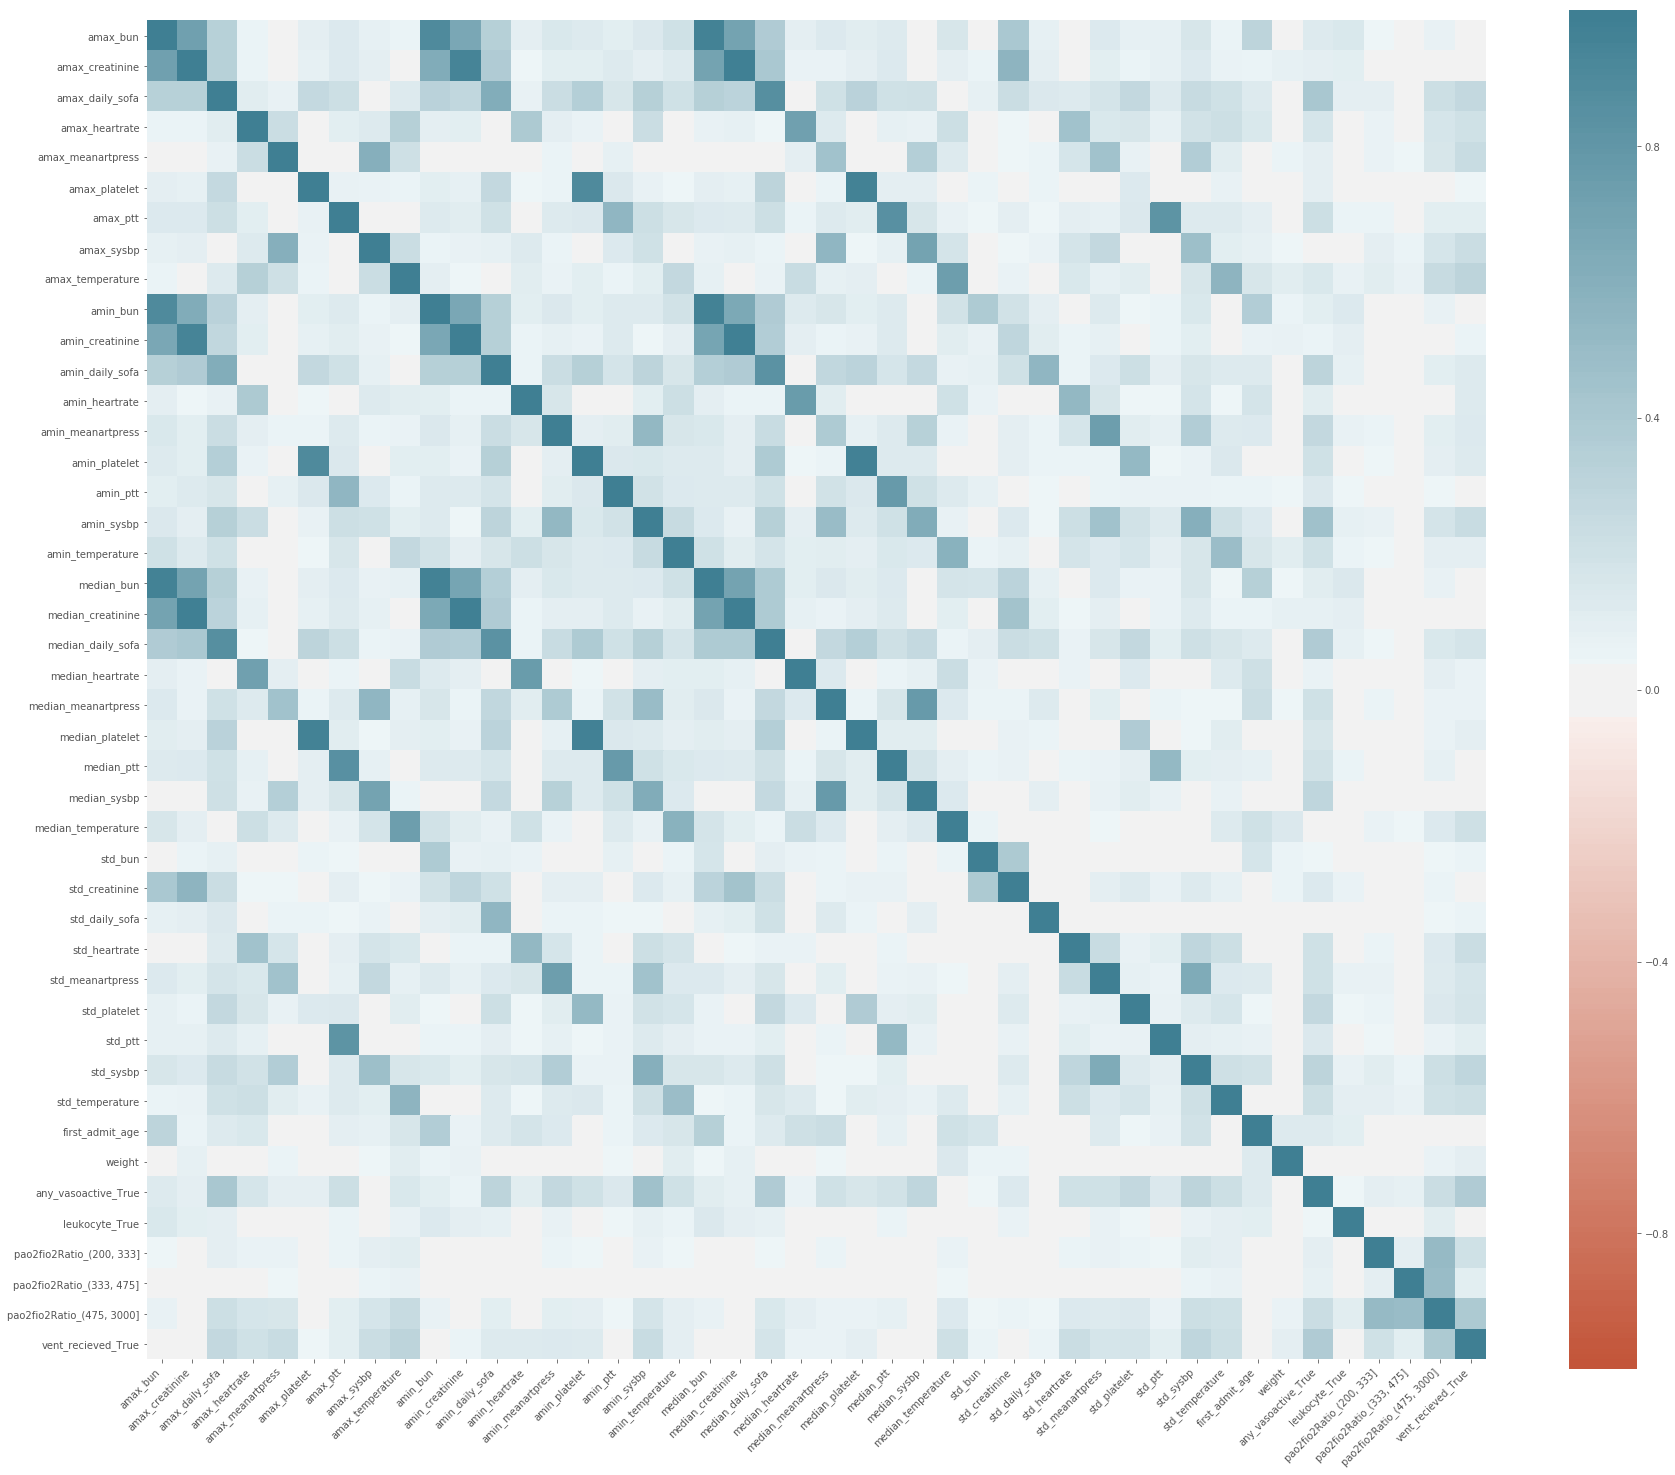

time: 1.53 s


In [18]:
corr = x_train.corr().abs()

plt.figure(figsize=(30, 25))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [19]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
cor_df=pd.DataFrame(sol)#.sort_values(kind="quicksort") #[-10:0])
cor_df=cor_df.reset_index()
cor_df=cor_df.rename(columns={'level_0': 'corx', 'level_1': 'cory', 0:'corr'})
cor_df2=cor_df[(cor_df['corx']!=cor_df['cory']) & (cor_df['corr']>0.7)].sort_values('corr', ascending=False)
cor_df2.head()

,corx,cory,corr
0,amax_creatinine,median_creatinine,0.982446
1,amin_creatinine,median_creatinine,0.978358
2,amin_platelet,median_platelet,0.969436
3,amax_bun,median_bun,0.965252
4,amin_bun,median_bun,0.963027


time: 19.9 ms


### DROPING one of the 2 columns with correlation >0.7

	corx	cory	corr
0	ipco2_absent	pao2fio2Ratio_(475, 3000]	0.872418
1	maxWBC	minWBC	0.802373
2	bun	creatinine	0.720861
3	maxSodium	minSodium	0.704233

In [20]:
x_train.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
x_test.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')

time: 3.78 ms


In [89]:
all_xy.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')

time: 3.03 ms


### formatting x and y for modleing

In [76]:
#x=np.array(x_train.iloc[:,[1,2,3,4,5,6,7,8,9,38,39,40,41]]).copy() #copy of x_train
#x=np.array(x_train.iloc[:,[1,2,3,4,5,6,7,8,9]]).copy() #copy of x_train
#x=np.array(x_train.iloc[:,38:])
x=np.array(x_train.copy())

#x=np.array(train_data.iloc[:,[1,2,3,4]]).copy() #copy of x_train
#train_data.iloc[:,[1,2,3,4,5]] ###drastically reducing my dataframe size to test algorithm
y=y_train.copy() #copy of y_train

##depreciated 5-16-19
# # ##all_xy: train data with finalbin:label and index=icustay_id
# # all_xy=train_data.copy().set_index("icustay_id").rename(columns={'final_bin':"label"}) #
# all_xy=None
# all_xy= x_train.copy()
# all_xy['icustay_id']=train_data['icustay_id']
# all_xy['label']=
# all_xy=all_xy.set_index('icustay_id').rename(columns={'final_bin':"label"})

time_interval=4

time: 16.3 ms


In [79]:
all_xy

,amax_meanartpress,amin_sysbp,amin_temperature,median_creatinine,median_daily_sofa,median_heartrate,median_platelet,median_ptt,median_sysbp,median_temperature,...,std_sysbp,std_temperature,first_admit_age,weight,any_vasoactive_True,leukocyte_True,"pao2fio2Ratio_(200, 333]","pao2fio2Ratio_(333, 475]","pao2fio2Ratio_(475, 3000]",vent_recieved_True
icustay_id,,,,,,,,,,,,,,,,,,,,,
200012,0.047571,-0.062544,-0.000410,0.000000,-0.500000,0.027988,-0.076639,-0.014210,-0.033701,-0.000410,...,0.011027,0.012918,-1.676892,-1.340521,0,0,0,0,1,0
200014,0.263979,-0.150392,-0.091478,-0.253202,-0.207519,-0.058109,-0.091332,-0.039732,0.045239,-0.023992,...,0.061265,0.028030,0.642448,-0.712853,0,0,1,0,0,1
200033,0.125991,-0.050656,-0.031509,-0.448205,-0.750000,0.062810,-0.086316,-0.056746,0.038885,0.007768,...,0.030143,0.027794,0.066739,-0.130908,1,0,0,0,1,1
200036,0.153843,-0.059526,-0.039920,-0.039957,-0.750000,0.062810,-0.041408,0.105303,0.027977,-0.023148,...,0.037232,0.015602,0.338118,0.084504,0,0,0,0,1,0
200059,0.196365,-0.158713,-0.149565,-0.039957,0.348079,0.021221,-0.021698,0.086332,0.023497,-0.029414,...,0.048045,0.036040,0.465886,-1.166122,1,0,1,0,0,1
200063,0.137417,-0.094577,-0.008636,0.707528,0.403677,0.000000,-0.041942,-0.088158,0.000000,0.059589,...,0.034404,0.025669,-1.392696,0.000000,0,0,0,0,1,1
200078,0.036308,-0.091210,-0.008636,0.034289,-0.048161,0.034613,0.098681,0.015733,-0.056540,0.029210,...,0.026049,0.012615,-0.005295,-0.244062,1,0,0,0,1,0
200091,0.145733,-0.074938,-0.042031,-0.079914,0.226723,-0.069301,-0.238431,0.056464,0.016645,-0.008636,...,0.036740,0.019968,0.159910,0.540090,0,0,0,1,0,1
200099,0.101873,-0.081338,-0.031509,0.347655,-0.048161,0.000000,-0.136609,-0.055494,-0.004936,-0.002462,...,0.033600,0.018066,0.491484,-0.507389,0,0,0,0,1,0


time: 56.5 ms


In [63]:
all_xy['label']= np.where(all_xy['label'] == 'C_neg/A_partial', 0, 1)

time: 2.23 ms


In [78]:
all_xy.iloc[1:5,20:40]
all_xy['label']

KeyError: 'label'

time: 44.9 ms


In [75]:
x_train

,amax_meanartpress,amin_sysbp,amin_temperature,median_creatinine,median_daily_sofa,median_heartrate,median_platelet,median_ptt,median_sysbp,median_temperature,...,std_sysbp,std_temperature,first_admit_age,weight,any_vasoactive_True,leukocyte_True,"pao2fio2Ratio_(200, 333]","pao2fio2Ratio_(333, 475]","pao2fio2Ratio_(475, 3000]",vent_recieved_True
0,0.047571,-0.062544,-0.000410,0.000000,-0.500000,0.027988,-0.076639,-0.014210,-0.033701,-0.000410,...,0.011027,0.012918,-1.676892,-1.340521,0,0,0,0,1,0
1,0.263979,-0.150392,-0.091478,-0.253202,-0.207519,-0.058109,-0.091332,-0.039732,0.045239,-0.023992,...,0.061265,0.028030,0.642448,-0.712853,0,0,1,0,0,1
2,0.125991,-0.050656,-0.031509,-0.448205,-0.750000,0.062810,-0.086316,-0.056746,0.038885,0.007768,...,0.030143,0.027794,0.066739,-0.130908,1,0,0,0,1,1
3,0.153843,-0.059526,-0.039920,-0.039957,-0.750000,0.062810,-0.041408,0.105303,0.027977,-0.023148,...,0.037232,0.015602,0.338118,0.084504,0,0,0,0,1,0
4,0.196365,-0.158713,-0.149565,-0.039957,0.348079,0.021221,-0.021698,0.086332,0.023497,-0.029414,...,0.048045,0.036040,0.465886,-1.166122,1,0,1,0,0,1
5,0.137417,-0.094577,-0.008636,0.707528,0.403677,0.000000,-0.041942,-0.088158,0.000000,0.059589,...,0.034404,0.025669,-1.392696,0.000000,0,0,0,0,1,1
6,0.036308,-0.091210,-0.008636,0.034289,-0.048161,0.034613,0.098681,0.015733,-0.056540,0.029210,...,0.026049,0.012615,-0.005295,-0.244062,1,0,0,0,1,0
7,0.145733,-0.074938,-0.042031,-0.079914,0.226723,-0.069301,-0.238431,0.056464,0.016645,-0.008636,...,0.036740,0.019968,0.159910,0.540090,0,0,0,1,0,1
8,0.101873,-0.081338,-0.031509,0.347655,-0.048161,0.000000,-0.136609,-0.055494,-0.004936,-0.002462,...,0.033600,0.018066,0.491484,-0.507389,0,0,0,0,1,0
9,0.156503,0.004854,0.005728,-0.208676,-0.603759,0.014305,0.100679,0.002138,0.073178,0.013868,...,0.032736,0.007502,0.301198,-0.130908,0,0,0,0,1,1


time: 50.5 ms


# Modelbuilding
* step1) hypertune xgb on 5fold cv.
* step2) test entire trainset and predict trainset.
* step3) run hypertuned model on 5fold cv with lr and get overall metrics.
* step4) local model testing

## step1) XGB hypertuning

In [22]:
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import log_loss
    
    y_hat = model.predict(test_features)
    errors = abs(y_hat - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    auc=roc_auc_score(test_labels, y_hat)
    loss= log_loss(test_labels, y_hat)
    
    print ('the AUC is: {:0.2f}'.format(auc))
    print ('the logloss is: {:0.2f}'.format(loss))
    print(confusion_matrix(test_labels, y_hat))
    
    return loss


time: 9.67 ms


In [29]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, base_model, scoring="neg_log_loss", gridsearch=True, n_iter=20): 
    if gridsearch==True:
        grid_search = GridSearchCV(estimator= model,
                                         param_grid=param_grid,
                                         cv=nfolds,
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    else:
        grid_search = RandomizedSearchCV(estimator= model,
                                         param_distributions= param_grid,
                                         n_iter=n_iter,
                                         cv=nfolds,
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    grid_search.fit(X, y)    
    
    print("Grid scores on development set:")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
    #grid_search.best_params_
    print(grid_search.best_score_)
    print("\n")
    print(grid_search.best_params_)
    
    print('\n base model (random_state 42):')
    base_model = base_model#(random_state = 42)
    base_model.fit(x, y)
    base_auc = evaluate(base_model, x, y)
    
    print('\n hypertuned model:')
    best_random = grid_search.best_estimator_
    random_auc = evaluate(best_random, x, y)

    print('logloss change of {:0.2f}%. after hypertuning on training set (may be overfit)'.format( 100 * (random_auc - base_auc) / base_auc))
    
    print(grid_search.best_estimator_)
    
    return(grid_search)

time: 71.9 ms


In [131]:
###xgboost
model= XGBClassifier(n_estimators=100, min_child_weight=2, #changed: GridSearchCV ->RandomizedSearchCV
                                              gamma=0, subsample=0.8, colsample_bytree=0.8,
                                              objective='binary:logistic', n_jobs=-1, seed=27)

scale_pos_weight = [0.1, 1, 5, 10]
max_depth = [1, 2, 3, 4, 5]
learning_rate=[0.01, 0.1, 0.5, 1]
param_grid = {'scale_pos_weight': scale_pos_weight, 'max_depth' : max_depth, "learning_rate":learning_rate}

base_model=XGBClassifier(random_state = 42)


xgboost_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=80, gridsearch=False)

Grid scores on development set:
-0.565 (+/-0.005) for {'scale_pos_weight': 0.1, 'max_depth': 1, 'learning_rate': 0.01}
-0.559 (+/-0.006) for {'scale_pos_weight': 1, 'max_depth': 1, 'learning_rate': 0.01}
-0.743 (+/-0.005) for {'scale_pos_weight': 5, 'max_depth': 1, 'learning_rate': 0.01}
-0.884 (+/-0.004) for {'scale_pos_weight': 10, 'max_depth': 1, 'learning_rate': 0.01}
-0.559 (+/-0.005) for {'scale_pos_weight': 0.1, 'max_depth': 2, 'learning_rate': 0.01}
-0.546 (+/-0.007) for {'scale_pos_weight': 1, 'max_depth': 2, 'learning_rate': 0.01}
-0.718 (+/-0.008) for {'scale_pos_weight': 5, 'max_depth': 2, 'learning_rate': 0.01}
-0.853 (+/-0.008) for {'scale_pos_weight': 10, 'max_depth': 2, 'learning_rate': 0.01}
-0.554 (+/-0.005) for {'scale_pos_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.01}
-0.537 (+/-0.009) for {'scale_pos_weight': 1, 'max_depth': 3, 'learning_rate': 0.01}
-0.697 (+/-0.013) for {'scale_pos_weight': 5, 'max_depth': 3, 'learning_rate': 0.01}
-0.826 (+/-0.012) for {'s

In [127]:
xgboost2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

time: 2.49 ms


In [94]:
xgb_hyper.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8)

time: 2.23 ms


In [88]:
###rf
# Number of trees in random forest
#n_estimators = [100, 1000]#[int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = [3,'auto', 10 ]
# Maximum number of levels in tree
max_depth = [5,10, 25]#[int(x) for x in np.linspace(5, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

#class_weight is either a dictionary of each class to a uniform weight for that class (e.g., {1:.9, 2:.5, 3:.01}), or is a string telling sklearn how to automatically determine this dictionary.
class_weight= [None,{0:1, 1:4}, {0:(1/np.bincount(y))[0], 1:(1/np.bincount(y))[1]}]


param_grid = {#'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight}


model= RandomForestClassifier(criterion='entropy')
base_model=RandomForestClassifier(random_state = 42, criterion='entropy')

rf_hyper=hypertuning_fxn(x, y, nfolds=5, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss",n_iter = 30, gridsearch=True)


Grid scores on development set:
-0.500 (+/-0.015) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
-0.500 (+/-0.015) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
-0.500 (+/-0.013) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
-0.499 (+/-0.011) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
-0.499 (+/-0.005) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 5}
-0.503 (+/-0.012) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 10}
-0.499 (+/-0.013) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
-0.501 (+/-0.012) for {'class_weight': None, 'max_depth': 5, 'max_features':

In [92]:
rf_hyper.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

time: 3.29 ms


## Hypertune SVC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# Take the first two features. We could avoid this by using a two-dim dataset
X = x[:,0:2]#iris.data[:, :2]
#y = #iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(list(x_train)[0])
    ax.set_ylabel(list(x_train)[1])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

In [133]:
model= svm.SVC(probability=True)
kernel = ['linear', 'rbf', 'poly']
gamma = [0.1, 1, 'auto'] #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default=’auto’ uses 1 / n_features
C = [0.1, 1, 10, 100] #Penalty parameter C of the error term.
degree = [0, 1, 2]
class_weight=['balanced', None]

param_grid = {'kernel': kernel,
              'gamma': gamma,
              'C': C,
              'degree': degree,
              'class_weight':class_weight}

base_model=svm.SVC(probability=True)

svc_hyper=hypertuning_fxn(x, y, nfolds=4, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=20, gridsearch=False)

KeyboardInterrupt: 

time: 3.75 s


In [134]:
svc_hyper.best_estimator_

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.1, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

time: 2.42 ms


# Hypertuned Model Initialization

In [135]:
xgboost= xgboost_hyper.best_estimator_
# xgboost = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#            colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
#            max_depth=3, min_child_weight=2, missing=None, n_estimators=100,
#            n_jobs=-1, nthread=None, objective='binary:logistic',
#            random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#            seed=27, silent=True, subsample=0.8)

logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                        intercept_scaling=1, class_weight='balanced', random_state=None)

rf= rf_hyper.best_estimator_
# rf= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#             max_depth=10, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=10, min_samples_split=10,
#             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
#             oob_score=False, random_state=None, verbose=0,
#             warm_start=False)


svc=svc_hyper.best_estimator_
# svc= svm.SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
#           decision_function_shape='ovr', degree=2, gamma=0.1, kernel='linear',
#           max_iter=-1, probability=True, random_state=None, shrinking=True,
#           tol=0.001, verbose=False)


time: 12.4 ms


In [136]:
def reset_model(model_name):
    if model_name== 'xgboost':
        model = xgboost_hyper.best_estimator_
        
    elif model_name== 'logreg':
        model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                intercept_scaling=1, class_weight='balanced', random_state=None)

    elif model_name== 'rf':
        model = rf_hyper.best_estimator_
    
    elif model_name== 'svc':
        model = svc_hyper.best_estimator_
    return(model)
#svc.fit(x, y)

time: 8.39 ms


# run hypertuned model on 5fold cv with lr and get overall metrics.
*<del> step1) hypertune xgb on 5fold cv.

* step2) run hypertuned model on 5fold cv with lr and get overall metrics.
* step3) test entire trainset and predict testset.
* step4) local model testing

In [137]:
def get_auc_score(model, train_index, x=x,y=y):
    y_pred_proba = model.predict_proba(x[train_index])[:, 1] 
    roc_score=roc_auc_score(y[train_index], y_pred_proba)
    return(roc_score)

time: 2.45 ms


In [104]:
#handwritten cv function
skf = StratifiedKFold(n_splits=5) #Stratified K-Folds cross-validator

xg_cv_auc = [] # xg auc of each cv rep
xg_cv_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_cv_auc = [] # lr auc of each cv rep
lr_cv_proba = [] # obtain the proba  of testing samples for one fold using lr

rf_cv_auc = [] # rf1 auc of each cv rep
rf_cv_proba = [] # obtain the proba  of testing samples for one fold using lr

svc_cv_auc = [] # rf1 auc of each cv rep
svc_cv_proba = [] # obtain the proba  of testing samples for one fold using lr


cv_y= []

for train_index, test_index in skf.split(x, y):   
#     xgboost = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=2,
#                             min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#                             objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
    xgboost = reset_model('xgboost')
    xgboost.fit(x[train_index], y[train_index])
    xgboost_auc= get_auc_score(xgboost, x=x,y=y, train_index=train_index)
    xgboost_pred_proba = xgboost.predict_proba(x[test_index])[:, 1]
    
    xg_cv_auc.append(xgboost_auc)
    xg_cv_proba.append(xgboost_pred_proba)
   
    #logistic reg
    logreg= reset_model('logreg')
    logreg.fit(x[train_index], y[train_index])
    logreg_auc= get_auc_score(logreg, x=x,y=y, train_index=train_index)
    logreg_pred_proba = logreg.predict_proba(x[test_index])[:, 1] 
    
    lr_cv_auc.append(logreg_auc)
    lr_cv_proba.append(logreg_pred_proba)
    
    ###random forest: had two very different best hyperparameters via 2 different cv methods.

    rf= reset_model('rf')
    
    rf.fit(x[train_index], y[train_index])
    rf_auc= get_auc_score(rf, x=x,y=y, train_index=train_index)
    rf_pred_proba = rf.predict_proba(x[test_index])[:, 1]   

    rf_cv_auc.append(rf_auc)
    rf_cv_proba.append(rf_pred_proba)
    
    
    svc= reset_model('svc')
    svc.fit(x[train_index], y[train_index])
    svc_auc= get_auc_score(svc, x=x,y=y, train_index=train_index)
    svc_pred_proba = svc.predict_proba(x[test_index])[:, 1] 
    
    svc_cv_auc.append(svc_auc)
    svc_cv_proba.append(svc_pred_proba)
    

    cv_y.append(y[test_index])
    
#xg_cv_auc_all= np.array(np.concatenate(xg_cv_auc))
xg_cv_proba= np.array(np.concatenate(xg_cv_proba))

#lr_cv_auc_all= np.array(np.concatenate(lr_cv_auc))
lr_cv_proba= np.array(np.concatenate(lr_cv_proba))

#rf1_cv_auc_all= np.array(np.concatenate(rf1_cv_auc))
rf_cv_proba= np.array(np.concatenate(rf_cv_proba))

svc_cv_proba= np.array(np.concatenate(svc_cv_proba))


cv_y_test=np.array(np.concatenate(cv_y))
one_fold_y_test = y[test_index]

print(pd.DataFrame({'xg':xg_cv_auc, 'lr':lr_cv_auc, 'rf':rf_cv_auc, 'svc':svc_cv_auc}))

         xg        lr        rf       svc
0  0.873055  0.754605  0.798740  0.755798
1  0.866896  0.749552  0.804191  0.751367
2  0.872864  0.749909  0.802974  0.752496
3  0.875194  0.753185  0.804556  0.754331
4  0.866993  0.746544  0.807677  0.748692
time: 2min 7s


In [138]:
#breaking this up into compartmentalized fxns
#def youden_index(y, y_hat_prob, pos_label=1)
def optimal_youden_index(fpr, tpr, thresholds):
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    
def plot_roc(fpr, tpr, roc_auc, roc_df, idx):
    plt.title('ROC with optimal Youden Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r", label="youden_optimal")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def classifier_eval2(y_proba, x=x, y=y, pos_label=1, print_default=True, print_classification_table=True):
    import sklearn.metrics as metrics

    """
    modified classifier_eval except doesn't require a model input, just a y_proba. easier to eval models w/ cv this way
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1
    
    this fxn is used to plot the classification model evaluation using both the 0.5 cutoff and the optimal youden cutoff for a given model
    
    """
    y_pred=[1 if y >= 0.5 else 0 for y in y_proba]

    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)

    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds)
    
    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx)
    
    #plotting confusion matrixs
   
    print("\n******* Using 0.5 Classification Threshold *******")
    np.set_printoptions(precision=2)
    print(confusion_matrix(y, y_pred))
    #plot_confusion_matrix(y, y_pred, title='Confusion matrix, 0.5 Prob')
#     plt.show()
    print ('the Accuracy is:',accuracy_score(y, y_pred))
    print("npv: ", (confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0))*100)
    print ('the classification_report:\n', classification_report(y,y_pred))


    
    print("\n******* Using Optimal Youden Classification Threshold *******")
    print("the Youden optimal index is : {:01.2f}".format(youden_threshold))
    y_pred_youden= [1 if y >= youden_threshold else 0 for y in y_proba]
    #plt.sca(axarr[0, 2])   
    #plot_confusion_matrix(y, y_pred_youden, title='Confusion matrix, {:01.2f} Prob'.format(youden_threshold))
    print(confusion_matrix(y, y_pred_youden))
    #plt.show()
    
    if print_classification_table==True:
        print ('the Accuracy is:',accuracy_score(y, y_pred_youden))
        print("npv: ", (confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0))*100)
        print ('the classification_report:\n', classification_report(y,y_pred_youden))
    else:
        pass
    

time: 154 ms


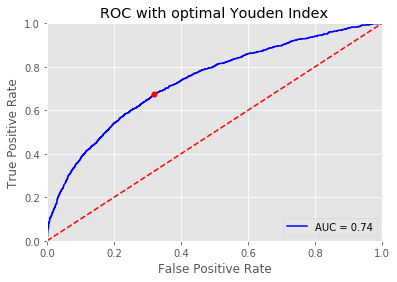


******* Using 0.5 Classification Threshold *******
[[3811  221]
 [1027  373]]
the Accuracy is: 0.7702503681885126
npv:  78.77221992558908
the classification_report:
               precision    recall  f1-score   support

           0       0.79      0.95      0.86      4032
           1       0.63      0.27      0.37      1400

   micro avg       0.77      0.77      0.77      5432
   macro avg       0.71      0.61      0.62      5432
weighted avg       0.75      0.77      0.73      5432


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.24
[[2741 1291]
 [ 456  944]]
the Accuracy is: 0.6783873343151694
npv:  85.73662808883327
the classification_report:
               precision    recall  f1-score   support

           0       0.86      0.68      0.76      4032
           1       0.42      0.67      0.52      1400

   micro avg       0.68      0.68      0.68      5432
   macro avg       0.64      0.68      0.64      5432
weighted avg       0.

In [139]:
classifier_eval2(y_proba=svc_cv_proba, x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

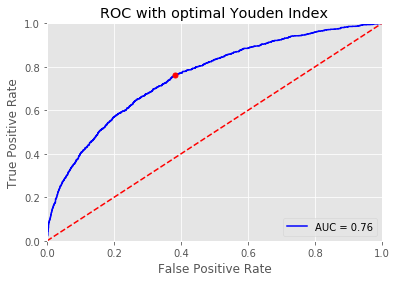


******* Using 0.5 Classification Threshold *******
[[3787  245]
 [ 975  425]]
the Accuracy is: 0.7754050073637703
npv:  79.52540949181017
the classification_report:
               precision    recall  f1-score   support

           0       0.80      0.94      0.86      4032
           1       0.63      0.30      0.41      1400

   micro avg       0.78      0.78      0.78      5432
   macro avg       0.71      0.62      0.64      5432
weighted avg       0.75      0.78      0.75      5432


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.21
[[2492 1540]
 [ 330 1070]]
the Accuracy is: 0.6557437407952872
npv:  88.3061658398299
the classification_report:
               precision    recall  f1-score   support

           0       0.88      0.62      0.73      4032
           1       0.41      0.76      0.53      1400

   micro avg       0.66      0.66      0.66      5432
   macro avg       0.65      0.69      0.63      5432
weighted avg       0.7

In [140]:
#testing classifier_eval2
#fig, axarr = plt.subplots(2, 3)     # 6 axes, returned as a 2-d array
classifier_eval2(y_proba=xg_cv_proba, x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)
#plt.show()

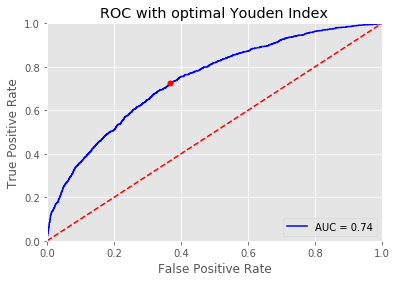


******* Using 0.5 Classification Threshold *******
[[3887  145]
 [1128  272]]
the Accuracy is: 0.7656480117820325
npv:  77.50747756729811
the classification_report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86      4032
           1       0.65      0.19      0.30      1400

   micro avg       0.77      0.77      0.77      5432
   macro avg       0.71      0.58      0.58      5432
weighted avg       0.74      0.77      0.71      5432


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.23
[[2546 1486]
 [ 383 1017]]
the Accuracy is: 0.6559278350515464
npv:  86.92386480027314
the classification_report:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73      4032
           1       0.41      0.73      0.52      1400

   micro avg       0.66      0.66      0.66      5432
   macro avg       0.64      0.68      0.63      5432
weighted avg       0.

In [142]:
classifier_eval2(y_proba=rf_cv_proba , x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

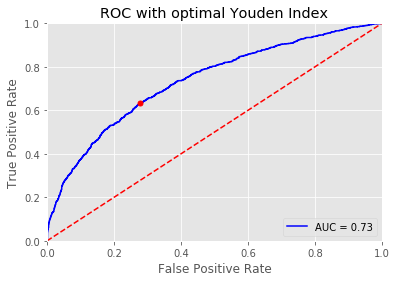


******* Using 0.5 Classification Threshold *******
[[2921 1111]
 [ 515  885]]
the Accuracy is: 0.7006627393225331
npv:  85.011641443539
the classification_report:
               precision    recall  f1-score   support

           0       0.85      0.72      0.78      4032
           1       0.44      0.63      0.52      1400

   micro avg       0.70      0.70      0.70      5432
   macro avg       0.65      0.68      0.65      5432
weighted avg       0.75      0.70      0.71      5432


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.50
[[2918 1114]
 [ 513  887]]
the Accuracy is: 0.7004786450662739
npv:  85.0480909355873
the classification_report:
               precision    recall  f1-score   support

           0       0.85      0.72      0.78      4032
           1       0.44      0.63      0.52      1400

   micro avg       0.70      0.70      0.70      5432
   macro avg       0.65      0.68      0.65      5432
weighted avg       0.75 

In [141]:
classifier_eval2(y_proba=lr_cv_proba , x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

# testing global model

## test entire trainset and predict trainset.
<del> * step1) hypertune xgb on 5fold cv.
    
<del> * step2) run hypertuned model on 5fold cv with lr and get overall metrics.
* step3) test entire train set and predict testset.
* step4) local model testing

In [75]:
#nicer confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, #classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    import matplotlib.pyplot as plt
    from sklearn import datasets
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    ax.grid(False) #remove gridlines for readability
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return (ax)


time: 65.5 ms


thresholds: 
* Decreasing thresholds on the decision function used to compute
    fpr and tpr. `thresholds[0]` represents no instances being predicted
    and is arbitrarily set to `max(y_score) + 1`.


In [76]:
# #setting up test table

# #print(pd.DataFrame({'xg':xg_cv_auc, 'lr':lr_cv_auc, 'rf':rf_cv_auc, 'svc':svc_cv_auc}))
# #pd.DataFrame({'model':[],'auc':[], 'precision':[], 'recall':[], 'f1':[]})
# test_summary_df= pd.DataFrame({'model':[],'auc':[], 'precision':[], 'recall':[], 'f1':[], 'npv':[]})
# test_summary_df

,model,auc,precision,recall,f1,npv


time: 9.15 ms


In [143]:
def classifier_eval(model, x=x, y=y, pos_label=1, print_default=True):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score

    """
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1
    
    this fxn is used to plot the classification model evaluation using both the 0.5 cutoff and the optimal youden cutoff for a given model
    
    """
    
    model_name=type(model).__name__
    
    y_pred = model.predict(x)
    y_proba = model.predict_proba(x)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)

    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds)
    
    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx)
    
    npv=confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0)*100
    prec= precision_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    recall= recall_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    f1= f1_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    
    if print_default==True: 
        #plotting confusion matrixs
        print("\n******* Using 0.5 Classification Threshold *******\n")
        #np.set_printoptions(precision=2)
        #plot_confusion_matrix(y, y_pred, title='Confusion matrix, 0.5 Prob')
        #plt.show()
        print(confusion_matrix(y, y_pred))
        print ('the Accuracy is: {:01.2f}'.format(accuracy_score(y, y_pred)))
        print ("npv: {:01.2f}".format(npv))
        print ('the classification_report:\n', classification_report(y,y_pred))
    else:
        pass
    
    print("\n******* Using Optimal Youden Classification Threshold *******\n")
    print("\nthe Youden optimal index is : {:01.2f}".format(youden_threshold))

    y_pred_youden= [1 if y >= youden_threshold else 0 for y in y_proba]
    

    npv_y=confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)*100
    prec_y= precision_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    recall_y= recall_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    f1_y= f1_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    auc_y=roc_auc_score(y_true=y, y_score= y_proba)
   
    print(confusion_matrix(y, y_pred_youden))
    print("the Accuracy is: {:01.2f}".format(accuracy_score(y, y_pred_youden)))
    print("npv: {:01.2f}".format(npv_y))
    print ('the classification_report:\n', classification_report(y,y_pred_youden))
    
          
    youden_dic= {'model':model_name, 'auc':auc_y, 'precision':prec_y, 'recall':recall_y, 'f1':f1_y, 'npv':npv_y}
    
    return(youden_dic)
    

time: 122 ms


In [123]:
list(x_train)

['amax_meanartpress',
 'amin_sysbp',
 'amin_temperature',
 'median_creatinine',
 'median_daily_sofa',
 'median_heartrate',
 'median_platelet',
 'median_ptt',
 'median_sysbp',
 'median_temperature',
 'std_bun',
 'std_creatinine',
 'std_daily_sofa',
 'std_heartrate',
 'std_meanartpress',
 'std_platelet',
 'std_ptt',
 'std_sysbp',
 'std_temperature',
 'first_admit_age',
 'weight',
 'any_vasoactive_True',
 'leukocyte_True',
 'pao2fio2Ratio_(200, 333]',
 'pao2fio2Ratio_(333, 475]',
 'pao2fio2Ratio_(475, 3000]',
 'vent_recieved_True']

time: 2.4 ms


### model fitting

In [144]:
xgboost = reset_model('xgboost')
xgboost.fit(x, y)

logreg = reset_model('logreg')
logreg.fit(x, y)

rf= reset_model('rf')
rf.fit(x,y)

# from sklearn.naive_bayes import GaussianNB
# gnb =GaussianNB()
# nb_y_pred = gnb.fit(x, y)

from sklearn import svm
svc= reset_model('svc')
svc.fit(x, y)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.1, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

time: 39.7 s


### global model test set evaluation

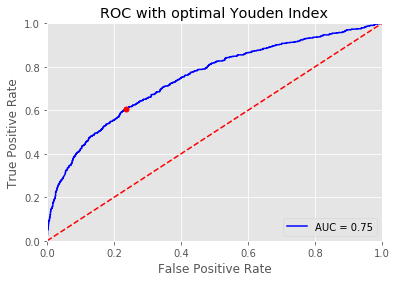


******* Using 0.5 Classification Threshold *******

[[1277  409]
 [ 249  393]]
the Accuracy is: 0.72
npv: 83.68
the classification_report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80      1686
           1       0.49      0.61      0.54       642

   micro avg       0.72      0.72      0.72      2328
   macro avg       0.66      0.68      0.67      2328
weighted avg       0.74      0.72      0.73      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.27
[[1291  395]
 [ 252  390]]
the Accuracy is: 0.72
npv: 83.67
the classification_report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      1686
           1       0.50      0.61      0.55       642

   micro avg       0.72      0.72      0.72      2328
   macro avg       0.67      0.69      0.67      2328
weighted avg       0.74      0.72      0.73      2328

time: 492 ms


In [145]:
svc_eval= classifier_eval(svc, x=np.array(x_test), y=y_test)

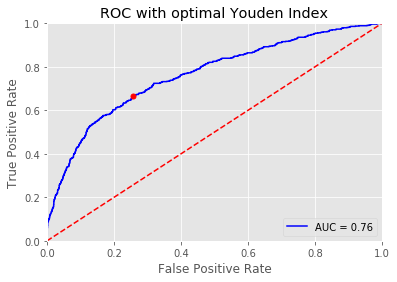


******* Using 0.5 Classification Threshold *******

[[1587   99]
 [ 426  216]]
the Accuracy is: 0.77
npv: 78.84
the classification_report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86      1686
           1       0.69      0.34      0.45       642

   micro avg       0.77      0.77      0.77      2328
   macro avg       0.74      0.64      0.65      2328
weighted avg       0.76      0.77      0.75      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.27
[[1255  431]
 [ 215  427]]
the Accuracy is: 0.72
npv: 85.37
the classification_report:
               precision    recall  f1-score   support

           0       0.85      0.74      0.80      1686
           1       0.50      0.67      0.57       642

   micro avg       0.72      0.72      0.72      2328
   macro avg       0.68      0.70      0.68      2328
weighted avg       0.76      0.72      0.73      2328

time: 193 ms


In [156]:
xgboost_eval= classifier_eval(xgboost, x=np.array(x_test), y=y_test)

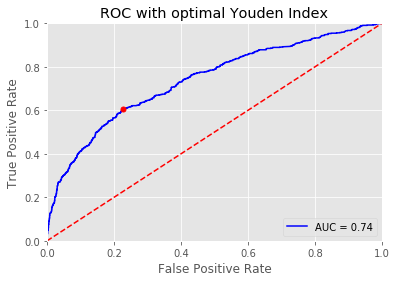


******* Using 0.5 Classification Threshold *******

[[1646   40]
 [ 513  129]]
the Accuracy is: 0.76
npv: 76.24
the classification_report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.86      1686
           1       0.76      0.20      0.32       642

   micro avg       0.76      0.76      0.76      2328
   macro avg       0.76      0.59      0.59      2328
weighted avg       0.76      0.76      0.71      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.30
[[1302  384]
 [ 253  389]]
the Accuracy is: 0.73
npv: 83.73
the classification_report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      1686
           1       0.50      0.61      0.55       642

   micro avg       0.73      0.73      0.73      2328
   macro avg       0.67      0.69      0.68      2328
weighted avg       0.75      0.73      0.73      2328

time: 163 ms


In [157]:
rf_eval= classifier_eval(rf, x=np.array(x_test), y=y_test)

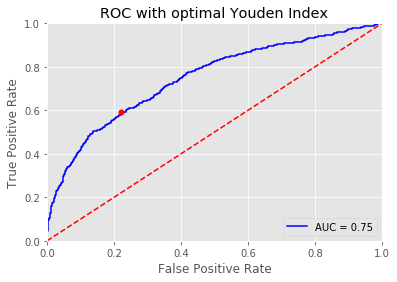


******* Using 0.5 Classification Threshold *******

[[1223  463]
 [ 238  404]]
the Accuracy is: 0.70
npv: 83.71
the classification_report:
               precision    recall  f1-score   support

           0       0.84      0.73      0.78      1686
           1       0.47      0.63      0.54       642

   micro avg       0.70      0.70      0.70      2328
   macro avg       0.65      0.68      0.66      2328
weighted avg       0.73      0.70      0.71      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.54
[[1313  373]
 [ 263  379]]
the Accuracy is: 0.73
npv: 83.31
the classification_report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81      1686
           1       0.50      0.59      0.54       642

   micro avg       0.73      0.73      0.73      2328
   macro avg       0.67      0.68      0.67      2328
weighted avg       0.74      0.73      0.73      2328

time: 180 ms


In [158]:
logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test)


In [152]:
#classifier_eval(gnb, x=x_test, y=y_test)

time: 533 µs


In [153]:
test_summary_df= pd.DataFrame([rf_eval,
                             logreg_eval,
                             xgboost_eval,
                             svc_eval])

time: 1.98 ms


In [178]:
test_summary_df.set_index('model').round(decimals=2)

,auc,f1,npv,precision,recall
model,,,,,
RandomForestClassifier,0.74,0.55,83.73,0.5,0.61
LogisticRegression,0.75,0.54,83.31,0.5,0.59
XGBClassifier,0.76,0.57,85.37,0.5,0.67
SVC,0.75,0.55,83.67,0.5,0.61


time: 16.8 ms


# variable importance

In [172]:
def var_imp(model):
    imp= model.feature_importances_
    var_index=[ x for x in range(0,len(rf.feature_importances_))]
    variables=list(x_train)
    return(pd.DataFrame({"imp":imp, 'index':var_index, 'variable': variables}).sort_values('imp', ascending=False))

time: 2.93 ms


In [174]:
var_imp(rf)

,imp,index,variable
1,0.167058,1,amin_sysbp
4,0.151216,4,median_daily_sofa
18,0.103138,18,std_temperature
22,0.063117,22,leukocyte_True
7,0.062012,7,median_ptt
9,0.053374,9,median_temperature
14,0.041837,14,std_meanartpress
12,0.039165,12,std_daily_sofa
5,0.038585,5,median_heartrate
13,0.034925,13,std_heartrate


time: 11.4 ms


In [173]:
var_imp(xgboost)

,imp,index,variable
4,0.128366,4,median_daily_sofa
1,0.101111,1,amin_sysbp
22,0.077747,22,leukocyte_True
25,0.065717,25,"pao2fio2Ratio_(475, 3000]"
18,0.041139,18,std_temperature
7,0.040136,7,median_ptt
0,0.038595,0,amax_meanartpress
9,0.038424,9,median_temperature
12,0.037390,12,std_daily_sofa
5,0.035574,5,median_heartrate


time: 18.7 ms


In [177]:
#var_imp(logreg)

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

time: 11.8 ms


# model pickling

In [ ]:
import pickle

# abandoned: making a classifier scorer method which 
* at first (#1) will try to maximize the accuracy at optimal youden index classification threshold.  
* once above works, will try to minimize the difference between (min(diagonal)-max(offdiagonal)) of confusion matrix.

this will be used in cv to best hyperparameterize

score_func : callable,
Score function (or loss function) with signature score_func(y, y_pred, **kwargs).

In [ ]:
# def youden_scorer(y, y_pred, pos_label=1):
#     #y_proba, x=x, y=y, pos_label=1
#     import sklearn.metrics as metrics
    
#     y_proba=y_pred.copy()
#     fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
#     roc_auc = metrics.auc(fpr, tpr)

#     #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden
#     youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds) #can optimize by removing roc_df, idx
#     del(roc_df, idx)
    
#     #******* Using Optimal Youden Classification Threshold *******
#     y_pred= [1 if y >= youden_threshold else 0 for y in y_proba]
#     accuracy_score=accuracy_score(y, y_pred)
#     return(accuracy_score)


In [ ]:
# from sklearn.metrics import make_scorer
# scorer=make_scorer(youden_scorer)

# scores = cross_val_score(rf_random, x, y, cv=5, scoring= scorer)

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(random_state = 2)
# clf.fit(X_train,y_train)
# # y_pred = clf.predict(X_test)  # default threshold is 0.5
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3

In [ ]:
# y_pred_random = rf_y_individual_pred
# y_proba_random = rf_y_individual_proba
# fpr, tpr, thresholds = metrics.roc_curve(y, rf_y_individual_proba, pos_label=1)
# #fpr, tpr, thresholds = metrics.roc_curve(y, rf_y_individual_proba, pos_label=1)
# roc_auc = metrics.auc(fpr, tpr)

# #making dataframe out of the thresholds
# xgb_roc= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
# xgb_roc.iloc[0,0] =1
# xgb_roc['yuden']= xgb_roc['tpr']-xgb_roc['fpr']
# idx=xgb_roc['yuden'].idxmax()
# xgb_roc.iloc[idx,:]
# youden_threshold=xgb_roc.iloc[idx,0]

# roc_auc = metrics.auc(fpr, tpr)

# plt.title('ROC with optimal Youden Index')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.plot(xgb_roc.iloc[idx,1], xgb_roc.iloc[idx,2],marker='o', markersize=5, color="r", label="youden_optimal")
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()


# #plotting confusion matrixs
# print("\n******* Using 0.5 Classification Threshold *******\n")
# np.set_printoptions(precision=2)
# plot_confusion_matrix(y, y_pred_random, title='Confusion matrix, 0.5 Prob')
# plt.show()
# print ('the Accuracy is:',accuracy_score(y, y_pred_random))
# print ('the classification_report:\n', classification_report(y,y_pred_random))


# print("\n******* Using Optimal Youden Classification Threshold *******\n")
# print("\nthe Youden optimal index is : {:01.2f}".format(youden_threshold))
# y_pred_random_youden=y_proba_random.copy()
# y_pred_random_youden[y_pred_random_youden>=youden_threshold]=1
# y_pred_random_youden[y_pred_random_youden<youden_threshold]=0
# plot_confusion_matrix(y, y_pred_random_youden, title='Confusion matrix, {:01.2f} Prob'.format(youden_threshold))
# plt.show()
# print ('the Accuracy is:',accuracy_score(y, y_pred_random_youden))
# print ('the classification_report:\n', classification_report(y,y_pred_random_youden))

In [ ]:
# #trying different cv algorithm

# from sklearn.model_selection import cross_val_score
# #clf = svm.SVC(kernel='linear', C=1)
# rf_random= RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
#             max_depth=10, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=4, min_samples_split=2)

# #making roc a scorer
# from sklearn.metrics import make_scorer
# scorer=make_scorer(roc_auc_score)

# scores = cross_val_score(rf_random, x, y, cv=5, scoring= scorer)
# scores     

## local model testing
*<del> step1) hypertune xgb on 5fold cv.

*<del> step2) test entire trainset and predict trainset.
    
*<del> step3) run hypertuned model on 5fold cv with lr and get overall metrics.
* step4) local model testing

In [ ]:
z_icustay_id

In [23]:
def single_split_training(m=250, n_sfk_split=5):
       
    #######
    skf = StratifiedKFold(n_splits=n_sfk_split) #Stratified K-Folds cross-validator
    num_fold = 0
    
    for train_index, test_index in skf.split(x, y):
        X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
        y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold
    
    #######

        num_fold = num_fold + 1 ##silly to keep but it's from the loop
        print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 

        print('the number of testing samples in this fold:', test_index.size)

        train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
        test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

        xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
        xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

        lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
        lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

        ######
    
        indicator_time = 0 # the indicator
        for i, j in zip(test_z_icustay_id, test_index):  #looping through the zipped indicies of the test indicies/test icustay_id

            testing_sample_id = i #numerical index of first 1/2 of data ##??? this seems to be instead the    
            all_xy_0 = all_xy.loc[train_z_icustay_id] # select all TRAINING samples from  the current fold using icustay_id index
            all_xy_training = all_xy_0.append(all_xy.loc[i]) # append the current ith testing sample to the training set. 

            ###important parameter. was at 400, i changed to X
            m = m  # m is the number of similar cases or similar controls

            X_test_00 = x[j]
            y_test = y[j]

            X_test = X_test_00.reshape(1, -1)

            # print 'start selecting......'

            Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  #  individulization

            ix = np.isin(z_icustay_id, Id_train_set)
            Id_train_set_index = list(np.where(ix))

            # Id_train_set_index = np.argwhere(z_icustay_id == Id_train_set)

            X_train = x[Id_train_set_index]
            y_train = y[Id_train_set_index]

            #print('start training......')

            # scoring = 'roc_auc'

        # xgboost
        
            #hyper parameter tuning F1 from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 5}
            #hyper parameter tuning F1_macro from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 4, 'scale_pos_weight': 1}
            #hyper parameter tuning recall_macro from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 5}
            #hyper parameter tuning neg_log_loss from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 2, 'scale_pos_weight': 1}


            xgboost_mod = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=2,
                          min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                          objective='binary:logistic', nthread=-1, scale_pos_weight=1, seed=27)
            xgboost_mod.fit(x[Id_train_set_index], y[Id_train_set_index])
            xg_y_pred = xgboost_mod.predict(X_test)
            xg_y_pred_proba = xgboost_mod.predict_proba(X_test)[:,1]

            xg_one_fold_pred.append(xg_y_pred)
            xg_one_fold_proba.append(xg_y_pred_proba)

        # lr 

            logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                        intercept_scaling=1, class_weight='balanced', random_state=None)
            logreg.fit(x[Id_train_set_index], y[Id_train_set_index])
            lr_y_pred = logreg.predict(X_test)
            lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

            lr_one_fold_pred.append(lr_y_pred)
            lr_one_fold_proba.append(lr_y_pred_proba)

            indicator_time = indicator_time + 1
            # print 'the next testing sample and total samples:', indicator_time, test_index.size

        xg_y_individual_pred = np.array(xg_one_fold_pred)
        xg_y_individual_proba = np.array(xg_one_fold_proba)

        lr_y_individual_pred = np.array(lr_one_fold_pred)
        lr_y_individual_proba = np.array(lr_one_fold_proba)

        one_fold_y_test = y[test_index]

        print ('---------new fold---------------')
        print ('**** result of non-individual predictor using xgboost:')
        print ('the Accuracy of one fold:', accuracy_score(y[test_index], xg_y_individual_pred))
        print ('the AUC of one fold:', roc_auc_score(y[test_index], xg_y_individual_pred))
        print ('the classification_report :', classification_report(y[test_index], xg_y_individual_pred))
        print(confusion_matrix(y[test_index], xg_y_individual_pred))
        print("\n")

        print ('****this is the result of individual predictor using lr:')
        print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
        print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
        print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
        print(confusion_matrix(y[test_index], lr_y_individual_pred))
        print("\n")

time: 303 ms


In [ ]:
#do we have multiple models for each patient? if so how do we aggregate?

In [24]:
single_split_training(m=250,n_sfk_split=2 )

this is the results of the 1 fold in 5 folds:
the number of testing samples in this fold: 2716


IndexError: index 0 is out of bounds for axis 0 with size 0

time: 284 ms


In [ ]:
single_split_training(m=500,n_sfk_split=2 )

In [27]:
X_train_0

array([[ 0.15384315, -0.05952629, -0.01483687, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.06552402, -0.11563726, -0.023148  , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.02988034, -0.04204864,  0.03201707, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.03246678, -0.04775876, -0.00451679, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.01663438, -0.07493765, -0.00863566, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.0724392 , -0.02026603, -0.01276663, ...,  0.        ,
         1.        ,  1.        ]])

time: 5.51 ms


## debugging index error: index 0 is out of bounds for axis 0 with size 0

In [28]:
# testing the select train set fxn:
icustay_id= z_icustay_id
m=100
#######
skf = StratifiedKFold(n_splits=4) #Stratified K-Folds cross-validator
num_fold = 0

for train_index, test_index in skf.split(x, y):
    X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
    y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

    num_fold = num_fold + 1 ##silly to keep but it's from the loop
    print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 
    print('the number of testing samples in this fold:', test_index.size)

    train_icustay_id = icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_icustay_id = icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

    ######

    indicator_time = 0 # the indicator
    ##looping through the zipped indicies of the test_icustay and test row index.
    for i, j in zip(test_icustay_id, test_index): 

        #these three lines: for each sample in the test set individually, go through and add the test sample to the training data.
        testing_sample_id = i #   
        all_xy_0 = all_xy.loc[train_icustay_id] # select all TRAINING samples from  the current fold using icustay_id index
        all_xy_training = all_xy_0.append(all_xy.loc[i]) # append the current ith testing sample to the training set. 

        
        
        ###important parameter. was at 400, i changed to X
        m = m  # m is the number of similar cases or similar controls

        X_test_00 = x[j]
        y_test = y[j]

        X_test = X_test_00.reshape(1, -1)

        # print 'start selecting......'
        print(testing_sample_id)
        print(all_xy_training)
        print(m)

        Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  #  individulization

this is the results of the 1 fold in 5 folds:
the number of testing samples in this fold: 1358
200012
            amax_bun  amax_creatinine  amax_daily_sofa  amax_heartrate  \
icustay_id                                                               
224116     -0.087975        -0.079914        -0.500000        0.120179   
224143      0.658963         2.059278         0.403677        0.007234   
224167     -0.181044        -0.079914         0.160964        0.027988   
224179     -0.108854        -0.253202         0.292481        0.074574   
224258      0.056406         0.408760         0.000000        0.083117   
224288      0.350242         2.670075         0.160964       -0.055909   
224297      0.174374        -0.253202         0.160964        0.144210   
224312      0.216448         0.467559         0.403677        0.034613   
224327      0.389504         1.604134         0.953445        0.074574   
224362     -0.181044        -0.079914         0.160964        0.074574   
224372    

IndexError: index 0 is out of bounds for axis 0 with size 0

time: 196 ms


In [ ]:
def select_train_samples(sample_id, all_xy, m, time_interval):# m is number of similar cases or controls
    num_control = m   # the ratio of case and control is 1:2, 1:3,1:4
    
    ####not sure what this is doing.
    if time_interval == 24:
        top_con_variables = [False]*128
        mid_cat_variables = [True]*5
        age_variable = [False]
        next_cat_variables = [True]*10
        last_con_variables = [False]*2

        flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns
    else:
        top_con_variables = [False]*129  #there is another item in other hours
        mid_cat_variables = [True]*5
        age_variable = [False]
        next_cat_variables = [True]*10
        last_con_variables = [False]*2

        flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns
        
    ##all_xy = all_xy.fillna(np.nan) # fill empty with nan

    x_candidate_label = all_xy.loc[sample_id] # get the object sample
    x_candidate = x_candidate_label.drop('label')
    x_candidate_tem = x_candidate.as_matrix()
    testing_sample = x_candidate_tem.reshape(1, -1)  # covert into ....

    all_x_candidate_tem = all_xy.drop([sample_id], axis=0, inplace=False) # delete the object sample from whole set

# select similar cases
    all_cases = all_x_candidate_tem[all_x_candidate_tem.label == 1]
    all_cases_candidate = all_cases.drop(['label'], axis=1, inplace=False)
    gower_candidate_case = all_cases_candidate.values[:, :] # convert into ndarray

    Gower_Distance_1 = gower_distances(gower_candidate_case, testing_sample, categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
    Gower_Distance_2 = list(Gower_Distance_1)
    Gower_Distance_3 = pd.Series(Gower_Distance_2, index = all_cases_candidate.index)
    Gower_Distance_4 = Gower_Distance_3.sort_values(ascending=False)

    Id_selected_cases = Gower_Distance_4.index[:m].tolist() # the id set of the top m similar samples

# select similar controls
    all_controls = all_x_candidate_tem[all_x_candidate_tem.label == 0]
    all_controls_candidate = all_controls.drop(['label'], axis=1, inplace=False)
    gower_candidate_control = all_controls_candidate.values[:, :] # convert into ndarray

    Gower_Distance_11 = gower_distances(gower_candidate_control, testing_sample,categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
    Gower_Distance_22 = list(Gower_Distance_11)
    Gower_Distance_33 = pd.Series(Gower_Distance_22, index = all_controls_candidate.index)
    Gower_Distance_44 = Gower_Distance_33.sort_values(ascending=False)

    Id_selected_controls = Gower_Distance_44.index[:num_control].tolist() # the id set of the top m similar samples

    train_set_id = Id_selected_controls+Id_selected_cases

    train_set_id = np.array(train_set_id)
    return train_set_id

In [91]:
Id_train_set = select_train_samples(testing_sample_id, all_xy, m, time_interval)  #  individulization

time: 970 ms


In [ ]:
### FINALLY WORKS

In [93]:
testing_sample_id

200012

time: 1.7 ms


In [92]:
Id_train_set

array([246038, 253025, 207052, 286252, 268954, 216378, 227244, 243144,
       242677, 237423, 204549, 203626, 200059, 214483, 216786, 281099,
       254981, 215601, 238926, 274727, 221776, 242053, 214675, 213472,
       229501, 209934, 223602, 240819, 293246, 252333, 212388, 203284,
       295759, 200474, 256653, 294335, 228023, 273234, 299112, 227849,
       292409, 255377, 286433, 234751, 204767, 231907, 288929, 263353,
       226660, 296624, 242205, 261422, 220759, 270705, 271793, 244579,
       227462, 245785, 219248, 201074, 265091, 214170, 296711, 214547,
       240563, 269065, 277281, 236390, 203934, 266708, 208993, 252099,
       243190, 257871, 238327, 212571, 291983, 247363, 299102, 269758,
       219918, 257054, 277640, 245088, 298383, 246641, 256634, 275555,
       298481, 267026, 291117, 235541, 282822, 255354, 202212, 224093,
       280829, 234279, 242743, 258763, 252649, 243067, 283067, 288724,
       253431, 234172, 250865, 286061, 289491, 250500, 255292, 214219,
      

time: 2.8 ms


In [55]:
sample_id=testing_sample_id
all_xy=all_xy_training
m=200
time_interval=24

num_control = m   # the ratio of case and control is 1:2, 1:3,1:4

####not sure what this is doing.
if time_interval == 24:
    top_con_variables = [False]*128
    mid_cat_variables = [True]*5
    age_variable = [False]
    next_cat_variables = [True]*10
    last_con_variables = [False]*2

    flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns
else:
    top_con_variables = [False]*129  #there is another item in other hours
    mid_cat_variables = [True]*5
    age_variable = [False]
    next_cat_variables = [True]*10
    last_con_variables = [False]*2

    flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns

##all_xy = all_xy.fillna(np.nan) # fill empty with nan

x_candidate_label = all_xy.loc[sample_id] # get the object sample
x_candidate = x_candidate_label.drop('label')
x_candidate_tem = x_candidate.as_matrix()
testing_sample = x_candidate_tem.reshape(1, -1)  # covert into ....

###all working above####

all_x_candidate_tem = all_xy.drop([sample_id], axis=0, inplace=False) # delete the object sample from whole set


# select similar cases
all_cases = all_x_candidate_tem[all_x_candidate_tem.label == 1]#'C_pos/A_full'] ####THIS IS THE LINE THAT IS BUGGING, NEED TO FIX THIS. 
all_cases_candidate = all_cases.drop(['label'], axis=1, inplace=False)
gower_candidate_case = all_cases_candidate.values[:, :] # convert into ndarray

Gower_Distance_1 = gower_distances(gower_candidate_case, testing_sample, categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
Gower_Distance_2 = list(Gower_Distance_1)
Gower_Distance_3 = pd.Series(Gower_Distance_2, index = all_cases_candidate.index)
Gower_Distance_4 = Gower_Distance_3.sort_values(ascending=False)

Id_selected_cases = Gower_Distance_4.index[:m].tolist() # the id set of the top m similar samples

# select similar controls
all_controls = all_x_candidate_tem[all_x_candidate_tem.label == 0]#'C_neg/A_partial']
all_controls_candidate = all_controls.drop(['label'], axis=1, inplace=False)
gower_candidate_control = all_controls_candidate.values[:, :] # convert into ndarray

Gower_Distance_11 = gower_distances(gower_candidate_control, testing_sample,categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
Gower_Distance_22 = list(Gower_Distance_11)
Gower_Distance_33 = pd.Series(Gower_Distance_22, index = all_controls_candidate.index)
Gower_Distance_44 = Gower_Distance_33.sort_values(ascending=False)

Id_selected_controls = Gower_Distance_44.index[:num_control].tolist() # the id set of the top m similar samples

train_set_id = Id_selected_controls+Id_selected_cases

train_set_id = np.array(train_set_id)

IndexError: index 0 is out of bounds for axis 0 with size 0

time: 145 ms


# TODO:

NEED TO ONEHOTENCODE ALL THINGS TO MATRIX. 

In [33]:
all_cases ###problem; this is empty

,amax_bun,amax_creatinine,amax_daily_sofa,amax_heartrate,amax_meanartpress,amax_platelet,amax_ptt,amax_sysbp,amax_temperature,amin_bun,...,std_ptt,std_sysbp,std_temperature,any_vasoactive,first_admit_age,leukocyte,pao2fio2Ratio,vent_recieved,weight,label
icustay_id,,,,,,,,,,,,,,,,,,,,,


time: 16.6 ms


In [42]:
all_x_candidate_tem

,amax_bun,amax_creatinine,amax_daily_sofa,amax_heartrate,amax_meanartpress,amax_platelet,amax_ptt,amax_sysbp,amax_temperature,amin_bun,...,std_ptt,std_sysbp,std_temperature,any_vasoactive,first_admit_age,leukocyte,pao2fio2Ratio,vent_recieved,weight,label
icustay_id,,,,,,,,,,,,,,,,,,,,,
224116,-0.087975,-0.079914,-0.500000,0.120179,0.153843,0.056465,-0.118071,0.107272,0.051909,-0.312219,...,0.012814,0.043046,0.015070,False,-0.725891,False,"(475, 3000]",True,0.166921,C_neg/A_partial
224143,0.658963,2.059278,0.403677,0.007234,0.065524,0.076059,0.032774,0.002437,-0.000410,0.452316,...,0.021663,0.027716,0.008390,False,-0.114415,False,"(475, 3000]",False,1.533795,C_neg/A_partial
224167,-0.181044,-0.079914,0.160964,0.027988,0.029880,0.172596,-0.063069,0.032390,0.063709,-0.209194,...,0.032630,0.020919,0.013493,False,-1.358684,False,"(475, 3000]",False,0.459037,C_neg/A_partial
224179,-0.108854,-0.253202,0.292481,0.074574,0.166931,-0.081420,-0.005400,0.172253,0.071911,-0.155149,...,0.018874,0.037934,0.018020,False,0.114840,False,"(475, 3000]",True,0.000000,C_neg/A_partial
224258,0.056406,0.408760,0.000000,0.083117,0.058460,0.013623,0.012640,0.023497,0.007768,-0.312219,...,0.032630,0.023747,0.016210,False,-1.186713,False,"(475, 3000]",False,0.000000,C_neg/A_partial
224288,0.350242,2.670075,0.160964,-0.055909,0.031176,0.164508,0.062828,0.061535,-0.014837,0.093070,...,0.060053,0.036070,0.010577,False,-0.039224,False,"(475, 3000]",False,0.802488,C_neg/A_partial
224297,0.174374,-0.253202,0.160964,0.144210,0.277081,-0.022907,-0.076057,0.146792,0.038014,-0.240028,...,0.022805,0.040882,0.018360,False,-1.783879,True,"(475, 3000]",True,0.000000,C_neg/A_partial
224312,0.216448,0.467559,0.403677,0.034613,0.012554,-0.105341,0.076101,0.027977,-0.000410,0.155882,...,0.018800,0.027915,0.019704,False,0.530621,False,"(475, 3000]",False,0.000000,C_neg/A_partial
224327,0.389504,1.604134,0.953445,0.074574,0.095556,0.007448,0.542324,0.049399,0.003685,0.104422,...,0.181945,0.043557,0.024786,True,-1.248740,False,"(475, 3000]",True,-1.279695,C_neg/A_partial


time: 79.6 ms


In [ ]:
#trying to collapse to get just 1 cv split index

skf = StratifiedKFold(n_splits=4, random_state=12345) #Stratified K-Folds cross-validator
num_fold = 0

#train_index, test_index in skf.split(x, y):

#splitting_test= skf.split(x,y)
#splitting_test.split(X, y[, groups])
for train_index, test_index in skf.split(x, y):
    print(train_index, test_index)
print(train_index, test_index)
    
#     X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
#     y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

#     num_fold = num_fold + 1 ##silly to keep but it's from the loop
#     print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 
#     print('the number of testing samples in this fold:', test_index.size)

#     train_icustay_id = icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
#     test_icustay_id = icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

#     xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
#     xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

#     lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
#     lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

In [ ]:
for train_index, test_index in skf.split(x, y):
    X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
    y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

    num_fold = num_fold + 1 ##silly to keep but it's from the loop
    print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 
    print('the number of testing samples in this fold:', test_index.size)

    train_icustay_id = icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_icustay_id = icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

In [ ]:
X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

train_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
test_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

indicator_time = 0 # the indicator
##looping through the zipped indicies of the test_icustay and test row index.
for testing_sample_id, testing_index_id in zip(test_icustay_id, test_index): 

    #these 2 lines: for each sample in the test set individually, go through and add the test sample to the training data.
    all_xy_0 = all_xy.loc[train_icustay_id] # select all TRAINING samples from  the current fold using icustay_id index
    all_xy_training = all_xy_0.append(all_xy.loc[i]) # append the current ith testing sample to the training set. 

    
    
#     ###important parameter. was at 400, i changed to X
#     m = m  # m is the number of similar cases or similar controls

    X_test = x[testing_index_id].reshape(1,-1) #changed x_test_00 to this and made it more easy to understand. array[[xtest]]. 
                                #single sample being tested for
    y_test = y[testing_index_id] #the y label

#     # print 'start selecting......'

#     Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  #  individulization
m=200

#so gets the 200 closest training and 200 closest grower testing samples
Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  
    #testing_sample_id: so all testing 
    #all_xy_training:all training rows except with the single test sample appended
    #m: #
    #time_interval:w/e
    ##output: icustay_id of 200 closest training and 200 closest grower testing samples
    
# ix = np.isin(z_icustay_id, Id_train_set) #boolean vector where TRUE = for the m * 2 samples
# Id_train_set_index = list(np.where(ix))
# Id_train_set_index = np.argwhere(z_icustay_id == Id_train_set)

X_train = x[ix]# x[Id_train_set_index]
y_train = y[ix]# y[Id_train_set_index]

In [ ]:
time_interval = 24  # ,48,72,96,120,144]:
#x, y, z_icustay_id, all_xy = preprocessing(folder, time_interval)  # all_xy is for compute gower distance
num_splits=5
skf = StratifiedKFold(n_splits=num_splits)
num_fold = 0
for train_index, test_index in skf.split(x, y):
    print ('***************')
    # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
    X_train_0, X_test_0 = x[train_index], x[test_index]
    y_train_0, y_test_0 = y[train_index], y[test_index]

    print( '#####################')

    num_fold = num_fold + 1
    print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

    print ('the number of testing samples in this fold:', test_index.size)

    train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

    indicator_time = 0 # the indicator
    for testing_sample_icu, testing_sample_index in zip(test_z_icustay_id, test_index):

        all_xy_cv = all_xy.loc[train_z_icustay_id] # select training samples from  5 fold
        all_xy_training = all_xy_cv.append(all_xy.loc[testing_sample_icu]) # note that , containing the i
        

        m = 200  # m is the number of similar cases or similar controls

        X_test = x[testing_sample_index].reshape(1, -1)
        y_test = y[testing_sample_index]

        # print 'start selecting......'

        Id_train_set = select_train_samples(testing_sample_icu, all_xy_training, m, time_interval)  #  individulization
        """
        #testing_sample_icu: so all testing icu's
        #all_xy_training:all training rows except with the single test sample appended
        #m: #
        #time_interval:w/e
        ##output: icustay_id of 200 closest training and 200 closest grower testing samples
        """
        ix = np.isin(z_icustay_id, Id_train_set)
        X_train=x[ix]# parameters for m*2 training set
        y_train=y[ix]# labels for m*2 training set
        
        ######modeling####
        
        ###logistic regression
        

        logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                    intercept_scaling=1, class_weight='balanced', random_state=None)
        logreg.fit(X_train, y_train)
        lr_y_pred = logreg.predict(X_test)
        lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

        lr_one_fold_pred.append(lr_y_pred)
        lr_one_fold_proba.append(lr_y_pred_proba)

        indicator_time = indicator_time + 1
    
    lr_y_individual_pred = np.array(lr_one_fold_pred)
    lr_y_individual_proba = np.array(lr_one_fold_proba)
    
    one_fold_y_test = y[test_index]
    print ('****this is the result of individual predictor using lr:')
    print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
    print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
    print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
    print(confusion_matrix(y[test_index], lr_y_individual_pred))


In [ ]:
def local_model(num_splits=2, m=200):
    
    """
    algorithm: first split into train and test set for cv: 
        now have full x, full y, xtrain/ytrain, xtest/ytest for each cv split.
        
        loop through each row in xtest:
            take the current xtest iteration and add it to all xtrain.
            find the M closest other rows based on grower distance.
            take these M rows and train a model on their features and outcome.
            use this model to predict the current xtest iteration. 
            add this prediction to a datastructure
    
    """
    
    time_interval = 24  # ,48,72,96,120,144]:
    #x, y, z_icustay_id, all_xy = preprocessing(folder, time_interval)  # all_xy is for compute gower distance
    #num_splits=5
    skf = StratifiedKFold(n_splits=num_splits)
    num_fold = 0
    for train_index, test_index in skf.split(x, y):
        print ('***************')
        # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
        X_train_0, X_test_0 = x[train_index], x[test_index]
        y_train_0, y_test_0 = y[train_index], y[test_index]

        print( '#####################')

        num_fold = num_fold + 1
        print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

        print ('the number of testing samples in this fold:', test_index.size)

        train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
        test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

        xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
        xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

        lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
        lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr
        
        lr_all_pred= []
        lr_all_proba= []

        indicator_time = 0 # the indicator
        for testing_sample_icu, testing_sample_index in zip(test_z_icustay_id, test_index):

            xy_cv = all_xy.iloc[train_index] # select training samples from  5 fold
            xy_training = xy_cv.append(xy_cv.loc[testing_sample_icu]) # append current iteration single test sample to all trainings

            #the clinical data for the single test sample in current iteration.
            X_test = x[testing_sample_index].reshape(1, -1) #single 
            y_test = y[testing_sample_index]
            if indicator_time%50==0:
                print("indicator_time:",indicator_time)
            else:
                pass

            Id_train_set = select_train_samples(testing_sample_icu, xy_training, m, time_interval)  #  individulization
            """
            #testing_sample_icu: single icustay_id of a patient.
            #all_xy_training:all training rows except with the single test sample in question appended
            #m: #
            #time_interval:w/e
            ##output: icustay_id of M closest training and M closest grower testing samples
            """
            ix = np.isin(z_icustay_id, Id_train_set) #boolean vector of which samples are in the train set
            X_train=x[ix]# parameters for m*2 training set
            y_train=y[ix]# labels for m*2 training set
            
            if indicator_time%50==0:
                print("x_train, y_train len:",len(X_train), len(y_train))
            else:
                pass

            ######modeling####

            ###logistic regression


            logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                        intercept_scaling=1, class_weight='balanced', random_state=None)
            logreg.fit(X_train, y_train)
            lr_y_pred = logreg.predict(X_test)
            lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

            lr_one_fold_pred.append(lr_y_pred)
            lr_one_fold_proba.append(lr_y_pred_proba)
            
            lr_all_pred.append(lr_y_pred)
            lr_all_proba.append(lr_y_pred_proba)

            indicator_time = indicator_time + 1

        lr_y_individual_pred = np.array(lr_one_fold_pred)
        lr_y_individual_proba = np.array(lr_one_fold_proba)

        print ('****this is the result of individual predictor using lr:')
        print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
        print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
        print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
        print(confusion_matrix(y[test_index], lr_y_individual_pred))


In [ ]:
#trying to implement without cv.   
time_interval = 24  # ,48,72,96,120,144]:

#m=200

train_z_icustay_id = z_icustay_id # the icustay_id of samples in training set from 5 fold
test_z_icustay_id = z_icustay_id # the icustay_id of samples in testing set from 5 fold

xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

lr_all_pred= []
lr_all_proba= []

indicator_time = 0 # the indicator
for testing_sample_icu, testing_sample_index in zip(z_icustay_id, range(0,len(z_icustay_id))):

#     xy_cv = all_xy.drop(train_index, axis=0) # select training samples from  5 fold
#     xy_training = xy_cv.append(xy_cv.loc[testing_sample_icu]) # append current iteration single test sample to all trainings

    #the clinical data for the single test sample in current iteration.
    X_test = x[testing_sample_index].reshape(1, -1) #single 
    y_test = y[testing_sample_index]
    if indicator_time%50==0:
        print("indicator_time:",indicator_time)
    else:
        pass

    Id_train_set = select_train_samples(testing_sample_icu, all_xy, m, time_interval)  #  individulization
    """
    #testing_sample_icu: single icustay_id of a patient.
    #all_xy_training:all training rows except with the single test sample in question appended
    #m: #
    #time_interval:w/e
    ##output: icustay_id of M closest training and M closest grower testing samples
    """
    ix = np.isin(z_icustay_id, Id_train_set) #boolean vector of which samples are in the train set
    X_train=x[ix]# parameters for m*2 training set
    y_train=y[ix]# labels for m*2 training set

    ######modeling####

    ###logistic regression


    logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                intercept_scaling=1, class_weight='balanced', random_state=None)
    logreg.fit(X_train, y_train)
    lr_y_pred = logreg.predict(X_test)
    lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

    lr_one_fold_pred.append(lr_y_pred)
    lr_one_fold_proba.append(lr_y_pred_proba)

    lr_all_pred.append(lr_y_pred)
    lr_all_proba.append(lr_y_pred_proba)
    
    indicator_time = indicator_time + 1

lr_y_individual_pred = np.array(lr_one_fold_pred)
lr_y_individual_proba = np.array(lr_one_fold_proba)

print ('****this is the result of individual predictor using lr:')
print ('the Accuracy of one fold:', accuracy_score(y, lr_y_individual_pred))
print ('the AUC of one fold:', roc_auc_score(y, lr_y_individual_pred))
print ('the classification_report :', classification_report(y, lr_y_individual_pred))
print(confusion_matrix(y, lr_y_individual_pred))

In [ ]:
m

In [ ]:
print ('****this is the result of individual predictor using lr:')
print ('the Accuracy of one fold:', accuracy_score(y, lr_y_individual_pred))
print ('the AUC of one fold:', roc_auc_score(y, lr_y_individual_pred))
print ('the classification_report :', classification_report(y, lr_y_individual_pred))
print(confusion_matrix(y, lr_y_individual_pred))

In [ ]:
classifier_eval2(y_proba=lr_y_individual_proba , x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

In [ ]:
all_xy.iloc[-5]

In [ ]:


#Id_train_set

#Id_train_set.isin(z_icustay_id[train_index])

len(set(Id_train_set) & set(z_icustay_id[train_index]))  #400

# len(set(Id_train_set) & set(z_icustay_id[test_index]))  #0

# #Id_train_set is in z_icustay_id[train_index]
#z_icustay_id[test_index]

In [ ]:
#ix = np.isin(z_icustay_id, Id_train_set) #boolean vector of which samples are in the train set
len(x[np.isin(z_icustay_id, Id_train_set)])# parameters for m*2 training set
#y_train=y[ix]# labels for m*2 training set

In [ ]:
len(X_train) #40
len(y_train) #40

In [ ]:
X_test

In [ ]:
len(x[ix])

In [ ]:
#[1 if y >= youden_threshold else 0 for y in y_proba]
sum([1 if x==True else 0 for x in ix])

In [ ]:
len(ix)

In [ ]:
# len(x) #5432
#len(y[test_index]) #2716
#len(lr_y_individual_proba) #1086

In [ ]:
y_test

In [ ]:
testing_sample_icu=299751
testing_sample_index=5416
test_output=select_train_samples(testing_sample_icu, all_xy_training, m, time_interval)
len(test_output) #400

In [ ]:
len(all_xy_cv)
print(len(y[test_index]), len(lr_y_individual_pred))

In [ ]:
local_model(num_splits=2, m=50)

In [ ]:
lr_one_fold_proba

In [ ]:
#debugging siz of X_train and y_train
num_splits=2
m=200
time_interval = 24  # ,48,72,96,120,144]:
#x, y, z_icustay_id, all_xy = preprocessing(folder, time_interval)  # all_xy is for compute gower distance
#num_splits=5
skf = StratifiedKFold(n_splits=num_splits)
num_fold = 0
for train_index, test_index in skf.split(x, y):
    print ('***************')
    # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
    X_train_0, X_test_0 = x[train_index], x[test_index]
    y_train_0, y_test_0 = y[train_index], y[test_index]

    print( '#####################')

    num_fold = num_fold + 1
    print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

    print ('the number of testing samples in this fold:', test_index.size)

    train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

    indicator_time = 0 # the indicator
    for testing_sample_icu, testing_sample_index in zip(test_z_icustay_id, test_index):

        all_xy_cv = all_xy.loc[train_z_icustay_id] # select training samples from  5 fold
        all_xy_training = all_xy_cv.append(all_xy.loc[testing_sample_icu]) # append current iteration single test sample to all trainings

        #the clinical data for the single test sample in current iteration.
        X_test = x[testing_sample_index].reshape(1, -1) #single 
        y_test = y[testing_sample_index]
        if indicator_time%50==0:
            print("indicator_time:",indicator_time)
        else:
            pass

        Id_train_set = select_train_samples(testing_sample_icu, all_xy_training, m, time_interval)  #  individulization
        """
        #testing_sample_icu: single icustay_id of a patient.
        #all_xy_training:all training rows except with the single test sample in question appended
        #m: #
        #time_interval:w/e
        ##output: icustay_id of M closest training and M closest grower testing samples
        """
        ix = np.isin(z_icustay_id, Id_train_set)
        X_train=x[ix]# parameters for m*2 training set
        y_train=y[ix]# labels for m*2 training set

In [ ]:
classifier_eval2(y_proba=lr_y_individual_proba , x=x[test_index], y=y[test_index], pos_label=1, print_default=True, print_classification_table=False)

In [ ]:
#next step, visualize each of the patient groups on the pca plot.

In [ ]:
# time_interval = 24  # ,48,72,96,120,144]:
# num_splits=5
# skf = StratifiedKFold(n_splits=num_splits)
# num_fold = 0
# for train_index, test_index in skf.split(x, y):
#     print ('***************')
#     # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
#     X_train_0, X_test_0 = x[train_index], x[test_index]
#     y_train_0, y_test_0 = y[train_index], y[test_index]

print( '#####################')

#num_fold = num_fold + 1
#print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

#print ('the number of testing samples in this fold:', test_index.size)

train_z_icustay_id = z_icustay_id#[train_index] # the icustay_id of samples in training set from 5 fold
test_z_icustay_id = z_icustay_id#[test_index] # the icustay_id of samples in testing set from 5 fold

xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

indicator_time = 0 # the indicator



for testing_sample_id, testing_sample_icu in zip(z_icustay_id, range(0,len(x))):
    m = 20  # m is the number of similar cases or similar controls

    X_test = x[testing_sample_icu].reshape(1, -1)
    y_test = y[testing_sample_icu]

    print('start selecting......')
    print("length xtest:",len(X_test))

    Id_train_set = select_train_samples(testing_sample_id, all_xy, m, time_interval)  #  individulization
    """
    #testing_sample_id: so all testing 
    #all_xy_training:all training rows except with the single test sample appended
    #m: #
    #time_interval:w/e
    ##output: icustay_id of 200 closest training and 200 closest grower testing samples
    """
    ix = np.isin(z_icustay_id, Id_train_set)
    X_train=x[ix]# parameters for m*2 training set
    y_train=y[ix]# labels for m*2 training set

    ######modeling####
    ###logistic regression

    logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                intercept_scaling=1, class_weight='balanced', random_state=None)
    logreg.fit(X_train, y_train)
    lr_y_pred = logreg.predict(X_test)
    lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

    lr_one_fold_pred.append(lr_y_pred)
    lr_one_fold_proba.append(lr_y_pred_proba)

    indicator_time = indicator_time + 1

lr_y_individual_pred = np.array(lr_one_fold_pred)
lr_y_individual_proba = np.array(lr_one_fold_proba)

one_fold_y_test = y[test_index]
print ('****this is the result of individual predictor using lr:')
print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
print(confusion_matrix(y[test_index], lr_y_individual_pred))